In [ ]:
!pip install yfinance ta xgboost plotly dash jupyter-dash backtrader --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.5 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import xgboost as xgb
import plotly.graph_objs as go
from datetime import datetime
import matplotlib.pyplot as plt


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator, ROCIndicator
from ta.trend import MACD, SMAIndicator

# --- Step 1: Download Stock Data ---
ticker = "DIA"
start_date = "2018-01-01"
end_date = "2024-12-31"

df = yf.download(ticker, start=start_date, end=end_date)
df.dropna(inplace=True)

# Ensure columns are 1D Series, not 2D
close = df['Close'].squeeze()
volume = df['Volume'].squeeze()

# --- Step 2: Add Technical Indicators ---
df['rsi'] = RSIIndicator(close=close, window=14).rsi()
df['macd'] = MACD(close=close).macd_diff()
df['sma_50'] = SMAIndicator(close=close, window=50).sma_indicator()
df['sma_200'] = SMAIndicator(close=close, window=200).sma_indicator()
df['volume_roc'] = ROCIndicator(close=volume, window=10).roc()

# Final cleanup
df.dropna(inplace=True)

# Preview
df.tail()


/tmp/ipython-input-44-3770575386.py:12: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open   Volume  \
Ticker             DIA         DIA         DIA         DIA      DIA   
Date                                                                  
2024-12-23  425.527222  426.072897  421.647875  423.949662  2602700   
2024-12-24  429.108948  429.237933  424.922034  425.527267  1431700   
2024-12-26  429.813385  430.269800  427.541362  427.590958  1867400   
2024-12-27  426.628571  428.900624  424.078713  427.204010  2429100   
2024-12-30  422.431702  424.306897  419.207184  422.134066  3858300   

Price             rsi      macd      sma_50     sma_200 volume_roc  
Ticker                                                              
Date                                                                
2024-12-23  40.098535 -2.501069  430.280367  402.139529  30.226158  
2024-12-24  45.896715 -1.945555  430.345063  402.380729 -41.824462  
2024-12-26  46.983637 -1.450151  430.490068  402.613831 -10.406371  
2024-12-27  42.797443 -1.263293  430.508516  402.828901 -32.248347  
2024-12-30  37.993399 -1.341327  430.408831  403.028625  51.400879

In [ ]:
!pip install lightgbm --quiet

In [ ]:

import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix

# Convert to NumPy arrays to avoid JSON character issues
X_train_np = X_train.values
X_test_np = X_test.values

# Train LightGBM
model = lgb.LGBMClassifier(n_estimators=1000)
model.fit(X_train_np, y_train)

# Evaluate
y_pred = model.predict(X_test_np)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"LightGBM Accuracy: {acc:.3f}")
print("Confusion Matrix:")
print(cm)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



[LightGBM] [Info] Number of positive: 663, number of negative: 585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1248, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531250 -> initscore=0.125163
[LightGBM] [Info] Start training from score 0.125163
LightGBM Accuracy: 0.519
Confusion Matrix:
[[72 64]
 [86 90]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



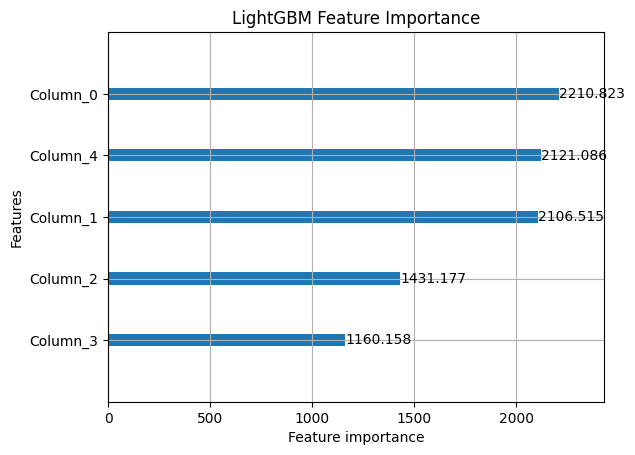

In [ ]:
lgb.plot_importance(model, importance_type='gain')
plt.title("LightGBM Feature Importance")
plt.show()


In [ ]:
# === Step 1: Clean base df ===
df_clean = df.dropna().copy()

# === Step 2: Build model inputs from clean df ===
X = df_clean[['rsi', 'macd', 'sma_50', 'sma_200', 'Close']]  # or however you defined X
y = (df_clean['Close'].shift(-1) > df_clean['Close']).astype(int)  # Up/Down labels
X = X[:-1]
y = y[:-1]

# === Step 3: Train-test split with aligned indices ===
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# === Step 4: Rebuild df_test from correct index ===
df_test = df_clean.loc[X_test.index].copy()


In [ ]:
df_test['prediction'] = model.predict(X_test)


In [ ]:
initial_cash = 100000
cash = initial_cash
position = 0
portfolio_value = []
position_history = []

for i in range(len(df_test)):
    price = df_test['Close'].iloc[i].item()
    pred = df_test['prediction'].iloc[i].item()

    if pred == 1 and cash >= 100 * price and position < 300:
        cash -= 100 * price
        position += 100
    elif pred == 0 and position >= 100:
        cash += 100 * price
        position -= 100

    total_value = cash + position * price
    portfolio_value.append(total_value)
    position_history.append(position)

df_test['portfolio'] = portfolio_value
df_test['position'] = position_history

# === Clean Buy & Hold Calculation ===
try:
    first_valid_price = df_test['Close'].dropna().iloc[0]
    df_test['buy_and_hold'] = initial_cash * (df_test['Close'] / first_valid_price)
except IndexError:
    df_test['buy_and_hold'] = np.nan  # fallback if Close is all NaNs

# === Quick sanity check ===
print("✅ Buy & Hold Values Head:\n", df_test['buy_and_hold'].head())
print("🟩 Total NaNs in buy_and_hold:", df_test['buy_and_hold'].isna().sum())


✅ Buy & Hold Values Head:
 Date
2023-10-03    100000.000000
2023-10-04    100306.058612
2023-10-05    100360.622048
2023-10-06    101248.529185
2023-10-09    101851.595242
Name: buy_and_hold, dtype: float64
🟩 Total NaNs in buy_and_hold: 0


In [ ]:
import plotly.graph_objs as go

# Create traces
trace1 = go.Scatter(
    x=df_test.index,
    y=df_test['portfolio'],
    mode='lines',
    name='Model Portfolio',
    line=dict(color='blue')
)

trace2 = go.Scatter(
    x=df_test.index,
    y=df_test['buy_and_hold'],
    mode='lines',
    name='Buy and Hold',
    line=dict(color='green', dash='dash')
)

# Layout
layout = go.Layout(
    title=f"Trading Strategy vs Buy & Hold: {ticker}",
    xaxis=dict(title='Date'),
    yaxis=dict(title='Portfolio Value'),
    template='plotly_white'
)

# Figure
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()


In [ ]:
pip install yfinance lightgbm --quiet


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

etfs = ['DIA', 'SPY', 'QQQ', 'IWM', 'VTI']
start_date = '2016-01-01'
end_date = '2023-12-31'
etf_data = {}

def compute_indicators(df):
    df['Return'] = df['Close'].pct_change()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['SMA_ratio'] = df['SMA_50'] / df['SMA_200']
    df['Volatility'] = df['Return'].rolling(window=20).std()
    df['Target'] = (df['Close'].shift(-5) > df['Close']).astype(int)
    return df.dropna()

for ticker in etfs:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df = compute_indicators(df)
    etf_data[ticker] = df


/tmp/ipython-input-123-2498626126.py:20: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/tmp/ipython-input-123-2498626126.py:20: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/tmp/ipython-input-123-2498626126.py:20: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/tmp/ipython-input-123-2498626126.py:20: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/tmp/ipython-input-123-2498626126.py:20: FutureWarning:

YF.download() has changed argument auto_adjust default to True



In [ ]:
import re

models = {}
features = ['Return', 'SMA_ratio', 'Volatility']

def clean_column_names(columns):
    return [re.sub(r'[^A-Za-z0-9_]', '', str(col)) for col in columns]

for ticker, df in etf_data.items():
    X = df[features].copy()
    y = df['Target']

    # Sanitize all column names strictly
    X.columns = clean_column_names(X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    model = lgb.LGBMClassifier(n_estimators=100)
    model.fit(X_train, y_train)

    df['Prediction'] = model.predict(X)
    etf_data[ticker] = df
    models[ticker] = model



[LightGBM] [Info] Number of positive: 886, number of negative: 564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611034 -> initscore=0.451663
[LightGBM] [Info] Start training from score 0.451663
[LightGBM] [Info] Number of positive: 913, number of negative: 537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.629655 -> initscore=0.530738
[LightGBM] [Info] Start training from score 0.530738
[LightGBM] [Info] Number of po

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def backtest(df):
    df = df.copy()
    cash = 100000
    position = 0
    portfolio_values = []

    for i in range(len(df)):
        price = df['Close'].iloc[i]
        signal = df['Prediction'].iloc[i]

        # ✅ Ensure signal is a scalar value
        if hasattr(signal, 'item'):
            signal = signal.item()
        signal = int(signal)

        # Buy or sell logic
        if signal == 1 and cash >= price * 100 and position < 300:
            cash -= price * 100
            position += 100
        elif signal == 0 and position >= 100:
            cash += price * 100
            position -= 100

        portfolio_value = cash + position * price
        portfolio_values.append(portfolio_value)

    df['Strategy'] = portfolio_values
    df['BuyHold'] = 100000 * df['Close'] / df['Close'].iloc[0]
    df['Daily_Return'] = df['Strategy'].pct_change().fillna(0)
    return df

def compute_sharpe(df):
    mean = df['Daily_Return'].mean()
    std = df['Daily_Return'].std()
    return (mean / std) * np.sqrt(252)


# Plot + Sharpe for each ETF
for ticker, df in etf_data.items():
    df = backtest(df)
    sharpe = compute_sharpe(df)
    print(f"{ticker} Sharpe Ratio: {sharpe:.2f}")

    plt.figure(figsize=(10, 4))
    plt.plot(df.index, df['Strategy'], label='Strategy')
    plt.plot(df.index, df['BuyHold'], label='Buy & Hold', linestyle='--')
    plt.title(f"{ticker} Strategy vs Buy & Hold")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
import yfinance as yf
import pandas as pd

# Download SPY daily data for the past 7 years
df = yf.download('SPY', start='2017-01-01', end='2024-12-31', progress=False)

# Display the first few rows
print(df.head())


/tmp/ipython-input-142-527785986.py:5: FutureWarning:

YF.download() has changed argument auto_adjust default to True



Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2017-01-03  196.117340  196.631052  194.933182  195.943189  91366500
2017-01-04  197.284073  197.432091  196.439489  196.448191  78744400
2017-01-05  197.127365  197.284099  196.326319  197.014183  78379000
2017-01-06  197.832626  198.302801  196.691993  197.240541  71559900
2017-01-09  197.179626  197.710756  197.144791  197.571441  46939700


In [ ]:
import numpy as np

# Flatten multi-index columns from yfinance
df.columns = df.columns.get_level_values(0)

# Sanitize column names
df.columns = [str(col).replace(" ", "_").replace("(", "").replace(")", "") for col in df.columns]

# Add basic indicators
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()
df['Momentum'] = df['Close'] - df['Close'].shift(10)

# Add binary target: 1 if price goes up next day, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Final cleaning
df = df.dropna().copy()

# Preview
print(df[['Close', 'SMA20', 'SMA50', 'Momentum', 'Target']].head())


                 Close       SMA20       SMA50  Momentum  Target
Date                                                            
2017-03-15  208.054718  206.366003  201.690051 -0.722656       0
2017-03-16  207.645508  206.520988  201.920615  0.182846       0
2017-03-17  207.280838  206.666449  202.120550 -0.312439       0
2017-03-20  207.053436  206.784430  202.319071  0.078369       0
2017-03-21  204.395020  206.708538  202.450319 -1.961853       1


[LightGBM] [Info] Number of positive: 856, number of negative: 713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1569, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545570 -> initscore=0.182789
[LightGBM] [Info] Start training from score 0.182789


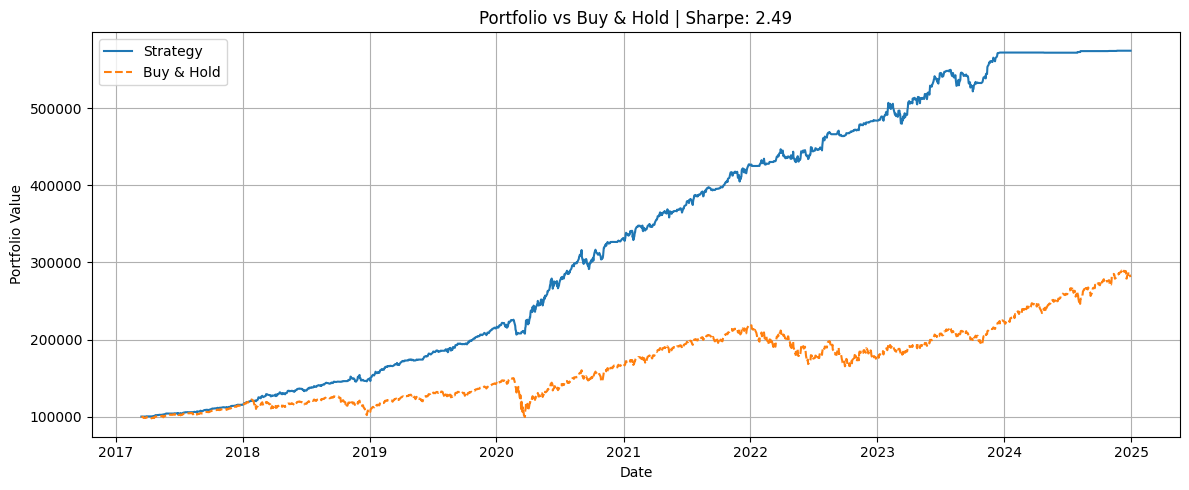

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# Features and labels
features = ['SMA20', 'SMA50', 'Momentum']
X = df[features].copy()
y = df['Target'].copy()

# LightGBM needs clean string feature names
X.columns = [str(c).replace(" ", "_").replace("(", "").replace(")", "") for c in X.columns]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train model
model = lgb.LGBMClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Predict on full set
df['Prediction'] = model.predict(X)

# Backtest simple strategy
initial_cash, position = 100000, 0
portfolio_values = []

for i in range(len(df)):
    price = df['Close'].iloc[i]
    signal = int(df['Prediction'].iloc[i])

    if signal == 1 and initial_cash >= price * 100:
        initial_cash -= price * 100
        position += 100
    elif signal == 0 and position >= 100:
        initial_cash += price * 100
        position -= 100

    total_value = initial_cash + position * price
    portfolio_values.append(total_value)

df['Strategy'] = portfolio_values
df['BuyHold'] = 100000 * df['Close'] / df['Close'].iloc[0]
df['DailyReturn'] = df['Strategy'].pct_change()
sharpe = (df['DailyReturn'].mean() / df['DailyReturn'].std()) * np.sqrt(252)

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(df['Strategy'], label='Strategy')
plt.plot(df['BuyHold'], label='Buy & Hold', linestyle='--')
plt.title(f"Portfolio vs Buy & Hold | Sharpe: {sharpe:.2f}")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-146-3232610100.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



[LightGBM] [Info] Number of positive: 856, number of negative: 713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1569, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545570 -> initscore=0.182789
[LightGBM] [Info] Start training from score 0.182789

📊 SPY | Sharpe: 3.40 | CAGR: 18.31%


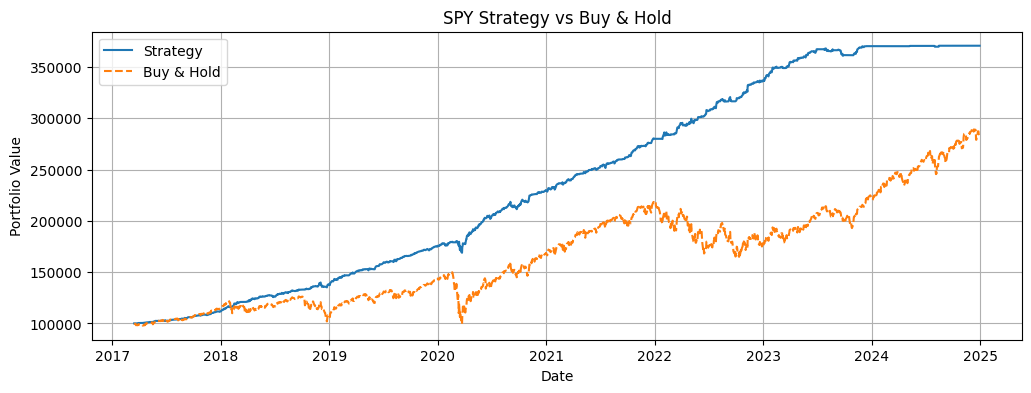

/tmp/ipython-input-146-3232610100.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



[LightGBM] [Info] Number of positive: 879, number of negative: 690
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1569, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560229 -> initscore=0.242093
[LightGBM] [Info] Start training from score 0.242093

📊 QQQ | Sharpe: 3.90 | CAGR: 19.21%


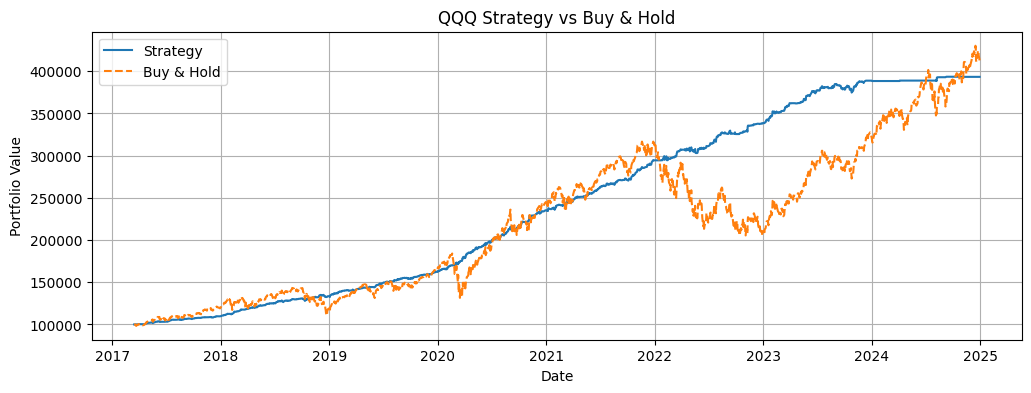

/tmp/ipython-input-146-3232610100.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



[LightGBM] [Info] Number of positive: 854, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1569, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544296 -> initscore=0.177649
[LightGBM] [Info] Start training from score 0.177649

📊 DIA | Sharpe: 2.90 | CAGR: 15.30%


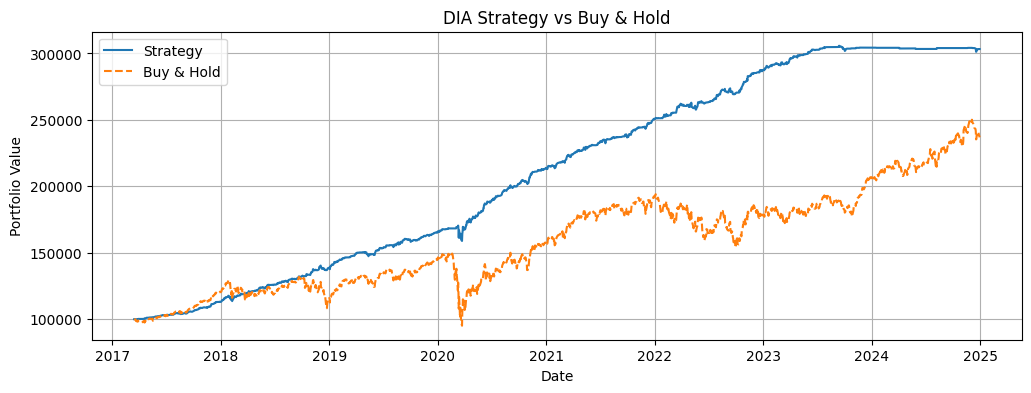

/tmp/ipython-input-146-3232610100.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



[LightGBM] [Info] Number of positive: 839, number of negative: 730
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1569, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534736 -> initscore=0.139166
[LightGBM] [Info] Start training from score 0.139166

📊 IWM | Sharpe: 3.58 | CAGR: 13.59%


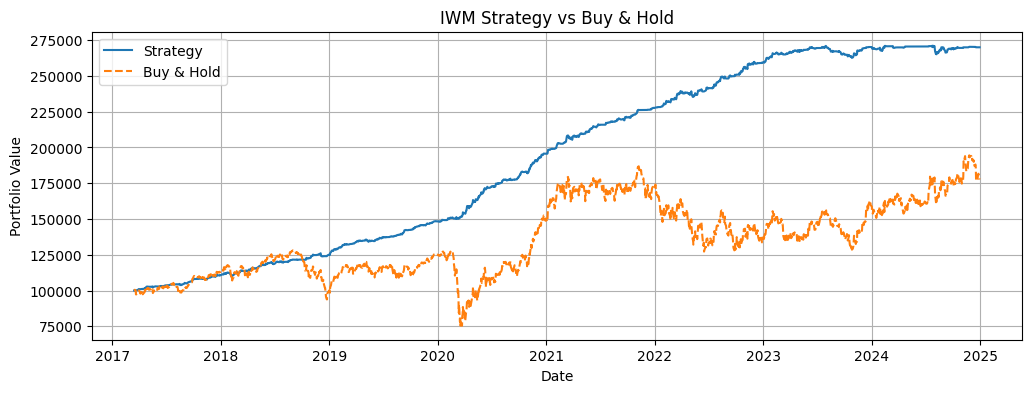

/tmp/ipython-input-146-3232610100.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



[LightGBM] [Info] Number of positive: 866, number of negative: 703
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1569, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551944 -> initscore=0.208528
[LightGBM] [Info] Start training from score 0.208528

📊 VTI | Sharpe: 3.53 | CAGR: 12.26%


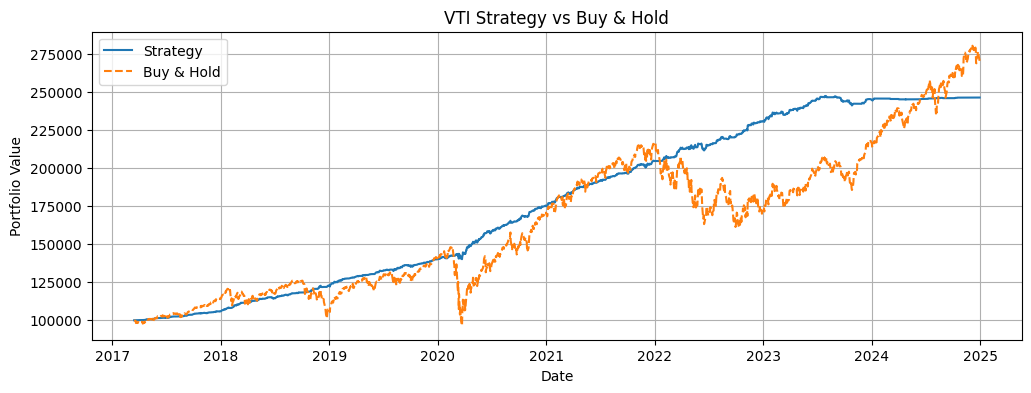

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# === Feature Engineering ===
def compute_features(df):
    df['SMA20'] = df['Close'].rolling(20).mean()
    df['SMA50'] = df['Close'].rolling(50).mean()
    df['Momentum'] = df['Close'].diff(4)
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    df.dropna(inplace=True)
    return df

def train_and_predict(df):
    features = ['SMA20', 'SMA50', 'Momentum']
    X = df[features]
    y = df['Target']

    X.columns = [str(col).replace(" ", "_").replace("(", "").replace(")", "") for col in X.columns]
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    model = lgb.LGBMClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    df['Prediction'] = model.predict(X)
    return df

def backtest(df):
    cash, position = 100000, 0
    portfolio = []
    for i in range(len(df)):
        price = df['Close'].iloc[i]
        signal = int(df['Prediction'].iloc[i])

        if signal == 1 and cash >= 100 * price and position < 300:
            cash -= 100 * price
            position += 100
        elif signal == 0 and position >= 100:
            cash += 100 * price
            position -= 100
        portfolio.append(cash + position * price)

    df['Strategy'] = portfolio
    df['BuyHold'] = 100000 * df['Close'] / df['Close'].iloc[0]
    df['Daily_Return'] = df['Strategy'].pct_change()
    return df

def compute_sharpe(df):
    return (df['Daily_Return'].mean() / df['Daily_Return'].std()) * np.sqrt(252)

def compute_cagr(df):
    start_val = df['Strategy'].iloc[0]
    end_val = df['Strategy'].iloc[-1]
    years = (df.index[-1] - df.index[0]).days / 365.25
    return (end_val / start_val) ** (1 / years) - 1

# === Main Analysis ===
tickers = ['SPY', 'QQQ', 'DIA', 'IWM', 'VTI']

for ticker in tickers:
    df = yf.download(ticker, start='2017-01-01', end='2024-12-31', progress=False)

    # Flatten multi-index if needed
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df = df[['Close']]
    df = compute_features(df)
    df = train_and_predict(df)
    df = backtest(df)

    sharpe = compute_sharpe(df)
    cagr = compute_cagr(df)

    print(f"\n📊 {ticker} | Sharpe: {sharpe:.2f} | CAGR: {cagr:.2%}")

    plt.figure(figsize=(12, 4))
    plt.plot(df['Strategy'], label='Strategy')
    plt.plot(df['BuyHold'], label='Buy & Hold', linestyle='--')
    plt.title(f"{ticker} Strategy vs Buy & Hold")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
print(df['Prediction'].value_counts())


Prediction
1    1038
0     924
Name: count, dtype: int64


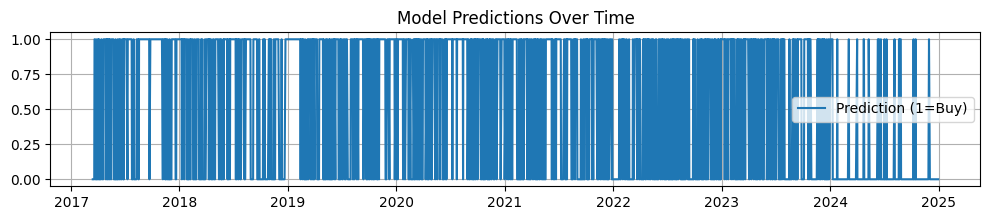

In [ ]:
plt.figure(figsize=(12, 2))
plt.plot(df['Prediction'], label='Prediction (1=Buy)')
plt.title('Model Predictions Over Time')
plt.grid(True)
plt.legend()
plt.show()



Processing SPY...


/tmp/ipython-input-6-4265243374.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-6-4265243374.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-6-4265243374.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.87 | CAGR: 14.37% | MaxDD: -29.64% | Calmar: 0.48 | Trades: 102


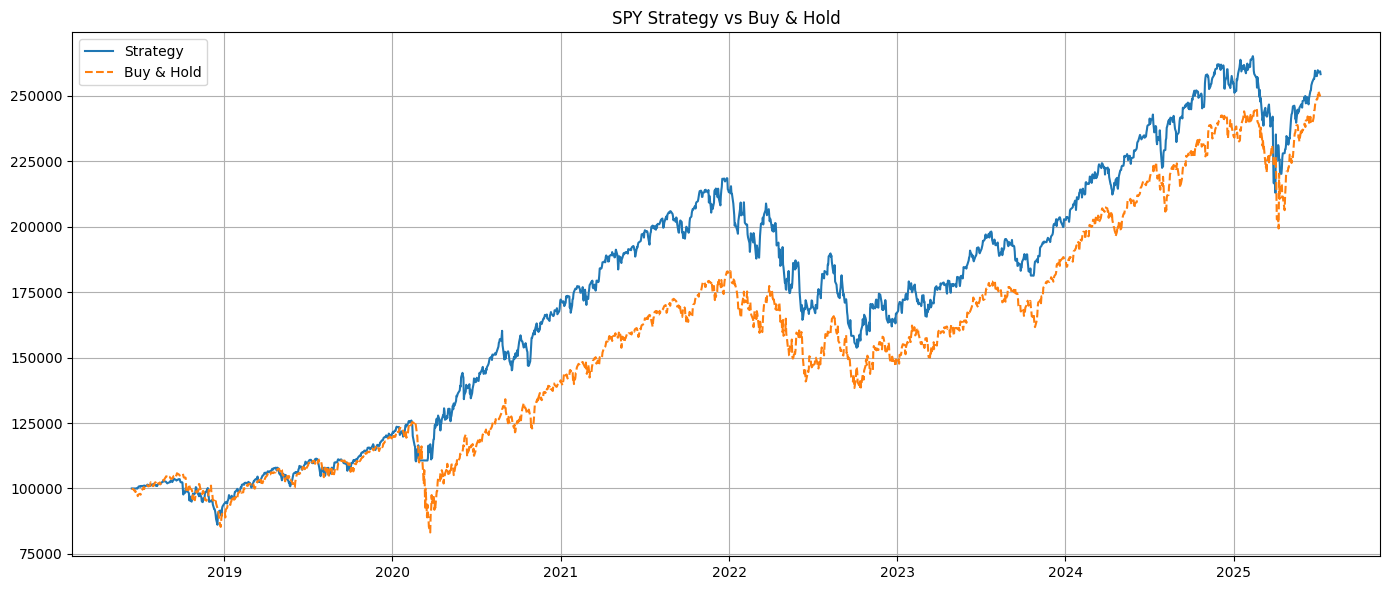


Processing QQQ...


/tmp/ipython-input-6-4265243374.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-6-4265243374.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-6-4265243374.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.78 | CAGR: 16.32% | MaxDD: -37.89% | Calmar: 0.43 | Trades: 210


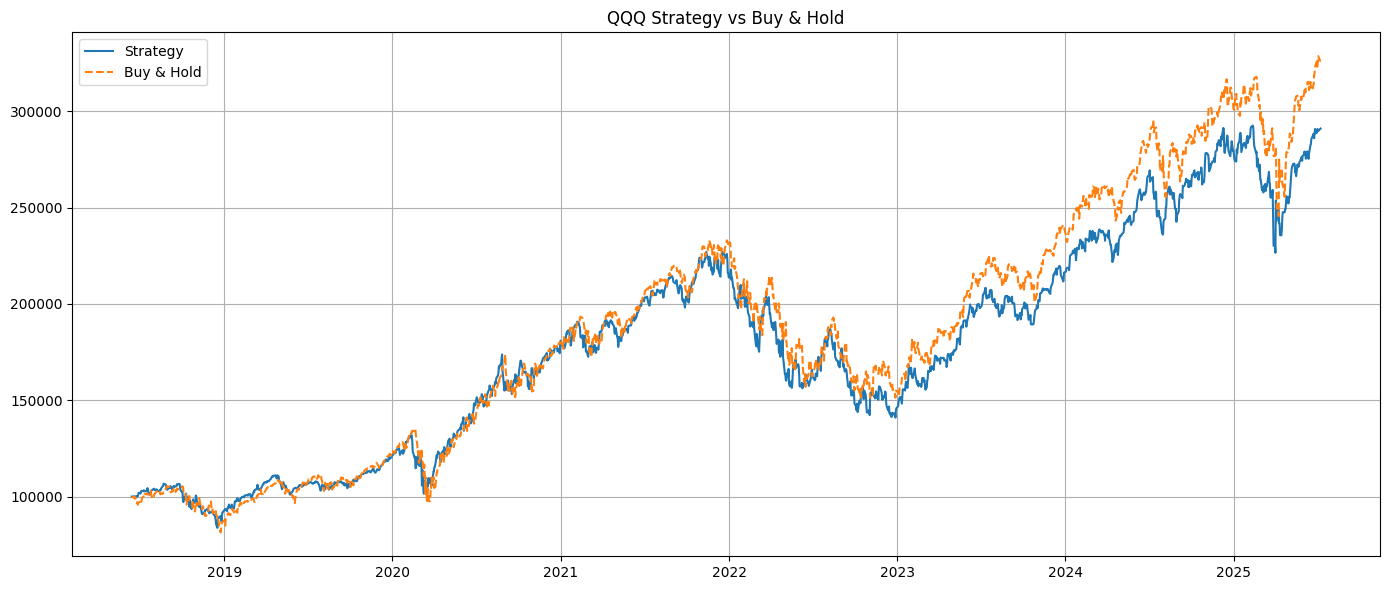


Processing DIA...


/tmp/ipython-input-6-4265243374.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-6-4265243374.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-6-4265243374.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.92 | CAGR: 14.23% | MaxDD: -21.77% | Calmar: 0.65 | Trades: 81


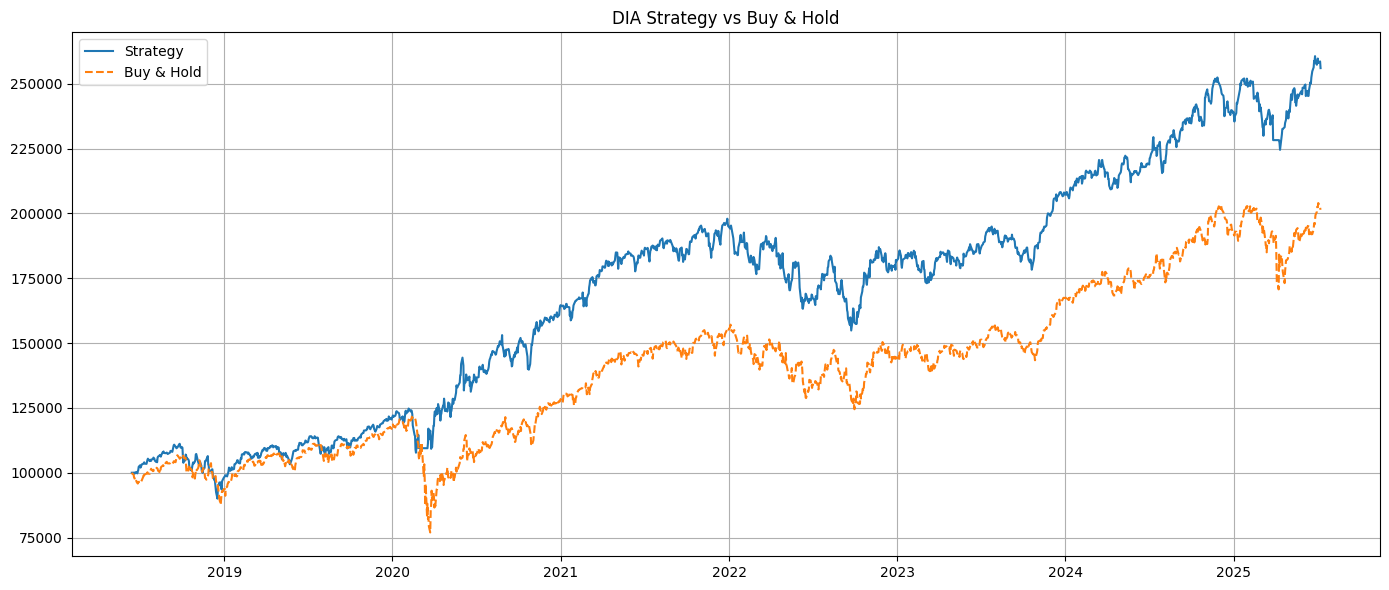


Processing IWM...


/tmp/ipython-input-6-4265243374.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-6-4265243374.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-6-4265243374.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.28 | CAGR: 3.90% | MaxDD: -44.47% | Calmar: 0.09 | Trades: 225


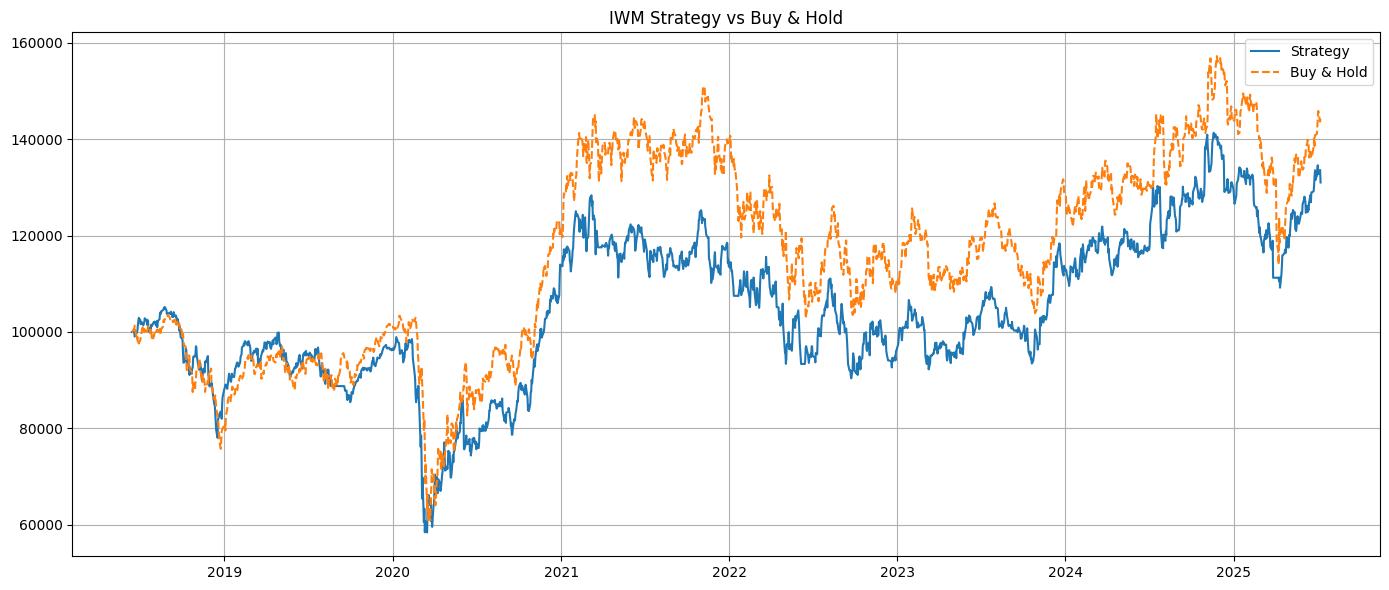


Processing VTI...


/tmp/ipython-input-6-4265243374.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-6-4265243374.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-6-4265243374.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.80 | CAGR: 13.17% | MaxDD: -26.28% | Calmar: 0.50 | Trades: 118


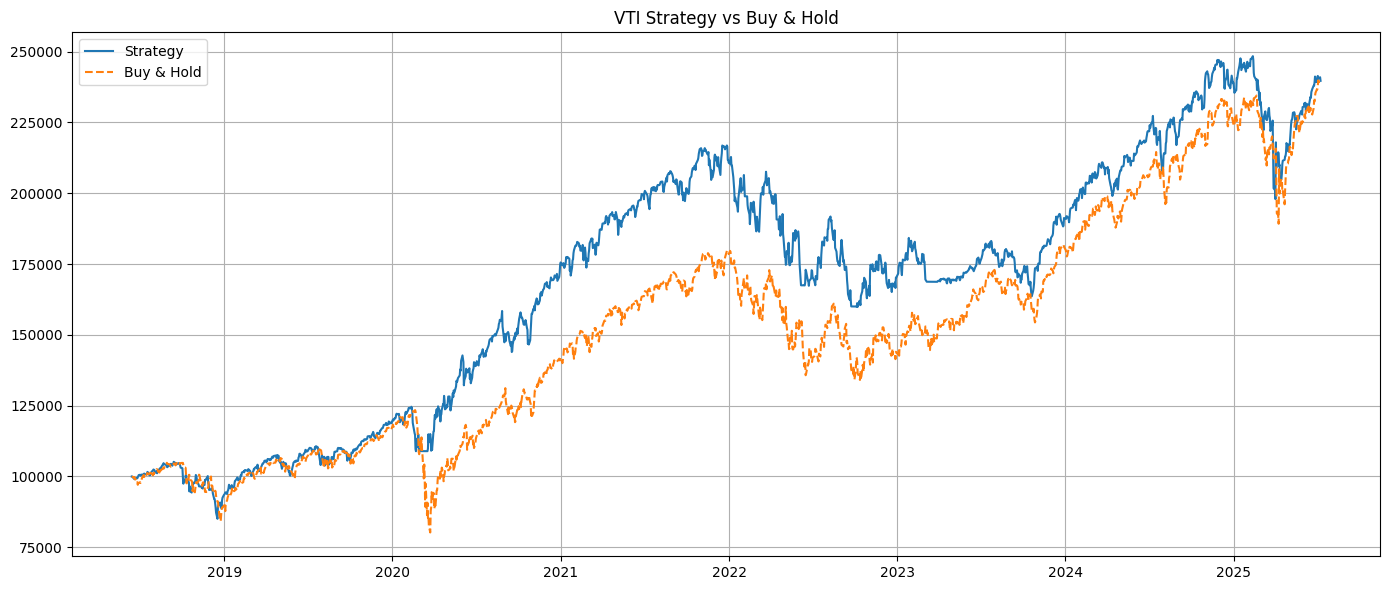

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# === Helper Indicators ===
def SMA(s, w): return s.rolling(w).mean()
def Momentum(s, p=10): return s - s.shift(p)
def ROC(s, n=10): return s.pct_change(n)
def RSI(s, p=14):
    delta = s.diff()
    gain, loss = delta.clip(lower=0), -delta.clip(upper=0)
    avg_gain = gain.rolling(p).mean()
    avg_loss = loss.rolling(p).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def MACD(s, f=12, sl=26, sig=9):
    ema1, ema2 = s.ewm(span=f, adjust=False).mean(), s.ewm(span=sl, adjust=False).mean()
    macd = ema1 - ema2
    return macd, macd.ewm(span=sig, adjust=False).mean()
def Bollinger(s, w=20, n=2):
    ma = s.rolling(w).mean()
    std = s.rolling(w).std()
    return ma + n * std, ma - n * std

# === Features ===
def compute_features(df):
    df['SMA20'] = SMA(df['Close'], 20)
    df['SMA50'] = SMA(df['Close'], 50)
    df['Momentum'] = Momentum(df['Close'], 10)
    df['RSI'] = RSI(df['Close'], 14)
    df['MACD'], df['MACD_sig'] = MACD(df['Close'])
    df['BB_up'], df['BB_low'] = Bollinger(df['Close'])
    df['Volatility'] = df['Close'].rolling(10).std()
    df['ROC'] = ROC(df['Close'], 5)
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    return df.dropna()

def backtest(df, initial_cash=100000, transaction_cost=0.0005, base_frac=0.3, trail_stop_pct=0.08):
    cash = initial_cash
    position = 0
    portfolio_values = []
    trades = []
    entry_price = 0
    peak_price = 0
    recent_exit = False

    for i in range(5, len(df)):  # start from 5 to compute trend slope
        price = df['Close'].iloc[i]
        pred = df['Prediction'].iloc[i]
        prob = df['Prediction_Prob'].iloc[i]
        rsi = df['RSI'].iloc[i]
        vol = df['Volatility'].iloc[i]
        sma20 = df['SMA20'].iloc[i]
        sma50 = df['SMA50'].iloc[i]

        # === Volatility Filter ===
        recent_avg_vol = df['Volatility'].rolling(30).mean().iloc[i]
        if vol > recent_avg_vol * 1.5:
            portfolio_values.append(cash + position * price)
            continue

        # === Trailing Stop ===
        if position > 0:
            peak_price = max(peak_price, price)
            if price < peak_price * (1 - trail_stop_pct):
                proceeds = position * price * (1 - transaction_cost)
                cash += proceeds
                trades.append((df.index[i], 'Trailing_Stop', position, price))
                position = 0
                recent_exit = True
                portfolio_values.append(cash)
                continue

        # === Trend Awareness ===
        trend_strength = sma50 - df['SMA50'].iloc[i - 5]
        allow_rsi = 70 if trend_strength > 0 else 60
        exit_prob_thresh = 0.45 if trend_strength > 0 else 0.5

        # === Entry/Exit Logic ===
        enter_long = (pred == 1) and (prob > 0.52) and (rsi < 65)
        exit_long = (pred == 0) and (prob < exit_prob_thresh) and (rsi > allow_rsi) and (price < sma20)

        # === Entry ===
        if enter_long and cash > price:
            dynamic_frac = base_frac + (prob - 0.5) * 0.8
            shares_to_buy = int((cash * dynamic_frac) // price)
            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + transaction_cost)
                cash -= cost
                position += shares_to_buy
                entry_price = price
                peak_price = price
                trades.append((df.index[i], 'Buy', shares_to_buy, price))
                recent_exit = False

        # === Re-entry After Exit if Trend Resumes ===
        elif enter_long and recent_exit and price > entry_price * 1.02:
            dynamic_frac = base_frac + (prob - 0.5) * 0.8
            shares_to_buy = int((cash * dynamic_frac) // price)
            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + transaction_cost)
                cash -= cost
                position += shares_to_buy
                entry_price = price
                peak_price = price
                trades.append((df.index[i], 'ReBuy', shares_to_buy, price))
                recent_exit = False

        # === Exit ===
        elif exit_long and position > 0:
            shares_to_sell = int(position * (0.5 + (0.5 - abs(prob - 0.5)) * 0.5))
            if shares_to_sell > 0:
                proceeds = shares_to_sell * price * (1 - transaction_cost)
                cash += proceeds
                position -= shares_to_sell
                trades.append((df.index[i], 'Sell', shares_to_sell, price))
                recent_exit = True

        total_value = cash + position * price
        portfolio_values.append(total_value)

    df = df.iloc[:len(portfolio_values)].copy()
    df['Strategy'] = portfolio_values
    df['BuyHold'] = initial_cash * df['Close'] / df['Close'].iloc[0]
    df['Daily_Return'] = df['Strategy'].pct_change().fillna(0)

    return df, trades


# === Metrics ===
def compute_sharpe(df): return (df['Daily_Return'].mean() / df['Daily_Return'].std()) * np.sqrt(252)
def compute_cagr(df):
    years = (df.index[-1] - df.index[0]).days / 365.25
    return (df['Strategy'].iloc[-1] / df['Strategy'].iloc[0]) ** (1 / years) - 1
def compute_max_drawdown(df):
    peak = df['Strategy'].cummax()
    dd = (df['Strategy'] - peak) / peak
    return dd.min()
def compute_calmar(df):
    dd = abs(compute_max_drawdown(df))
    return compute_cagr(df) / dd if dd > 0 else np.nan

# === Plotting ===
def plot_results(df, trades, ticker):
    plt.figure(figsize=(14,6))
    plt.plot(df.index, df['Strategy'], label='Strategy')
    plt.plot(df.index, df['BuyHold'], '--', label='Buy & Hold')
    plt.title(f'{ticker} Strategy vs Buy & Hold')
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# === Main Run ===
tickers = ['SPY', 'QQQ', 'DIA', 'IWM', 'VTI']
end = datetime.today()
start = end - timedelta(days=8*365)

for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), progress=False, auto_adjust=True)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df = compute_features(df[['Close']])
    df = rolling_train_predict(df)
    df, trades = backtest(df)
    sharpe, cagr = compute_sharpe(df), compute_cagr(df)
    max_dd, calmar = compute_max_drawdown(df), compute_calmar(df)
    print(f"Sharpe: {sharpe:.2f} | CAGR: {cagr:.2%} | MaxDD: {max_dd:.2%} | Calmar: {calmar:.2f} | Trades: {len(trades)}")
    plot_results(df, trades, ticker)



Processing SPY...


/tmp/ipython-input-3-2996925691.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-3-2996925691.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-3-2996925691.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.92 | CAGR: 15.20% | MaxDD: -29.52% | Calmar: 0.51 | Trades: 98


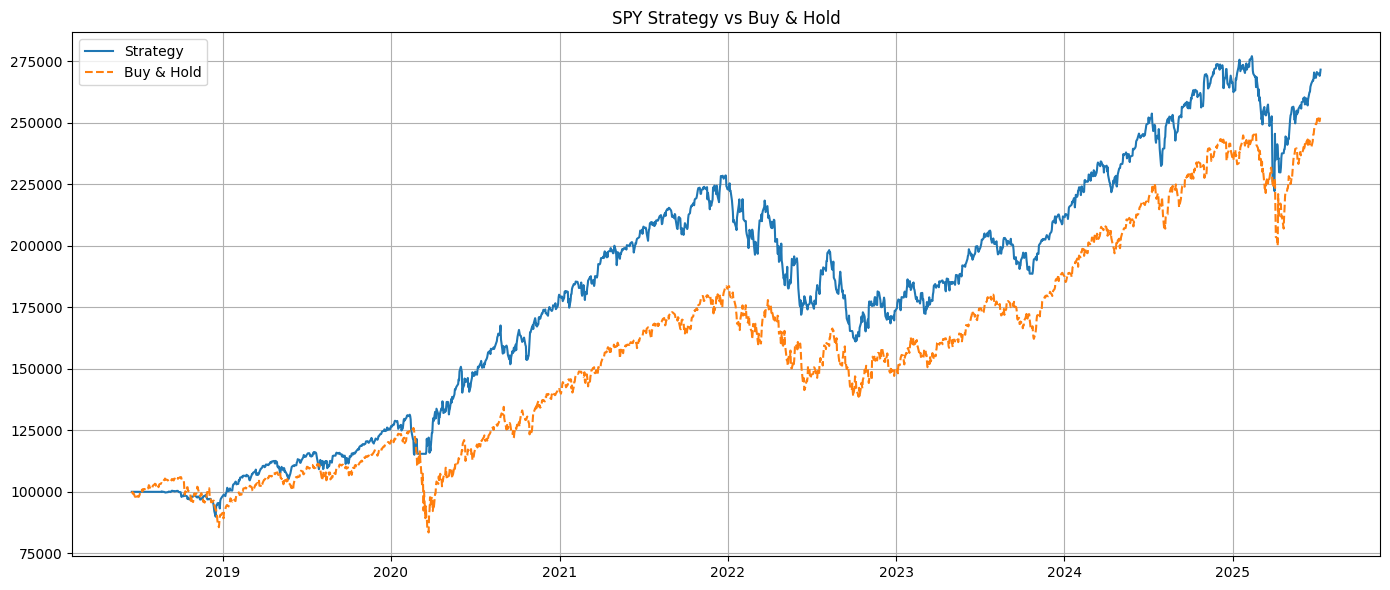


Processing QQQ...


/tmp/ipython-input-3-2996925691.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-3-2996925691.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-3-2996925691.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.79 | CAGR: 16.68% | MaxDD: -38.35% | Calmar: 0.43 | Trades: 201


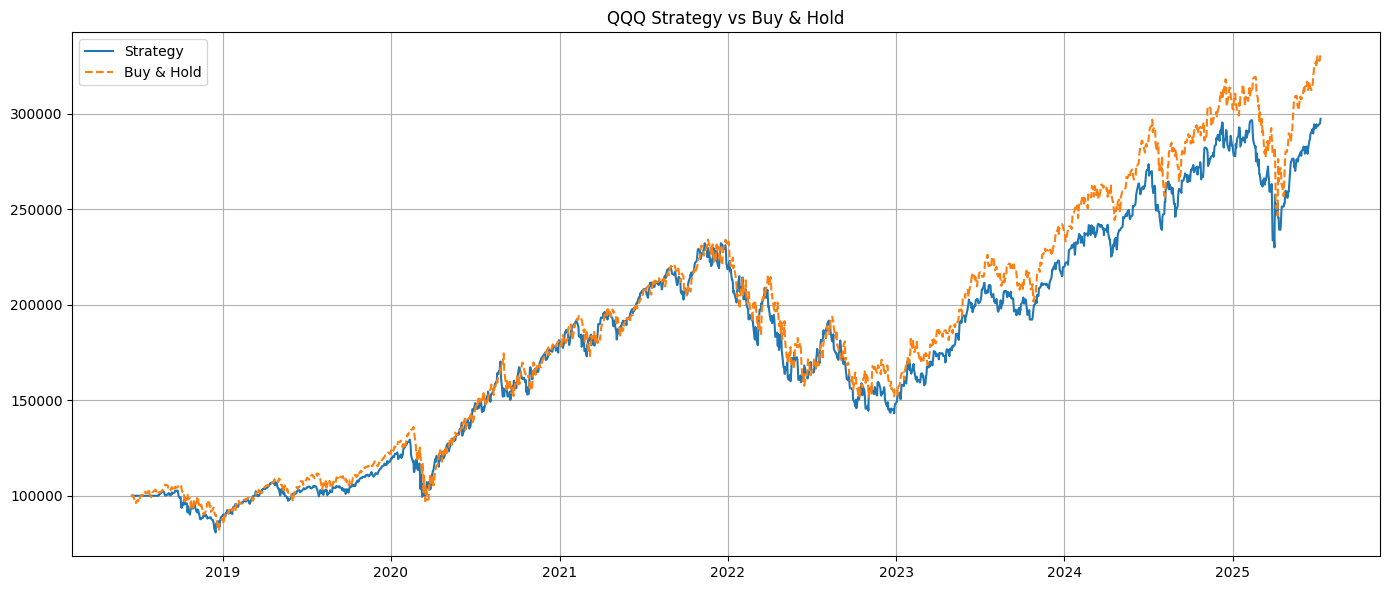


Processing DIA...


/tmp/ipython-input-3-2996925691.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-3-2996925691.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-3-2996925691.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.91 | CAGR: 13.92% | MaxDD: -21.88% | Calmar: 0.64 | Trades: 79


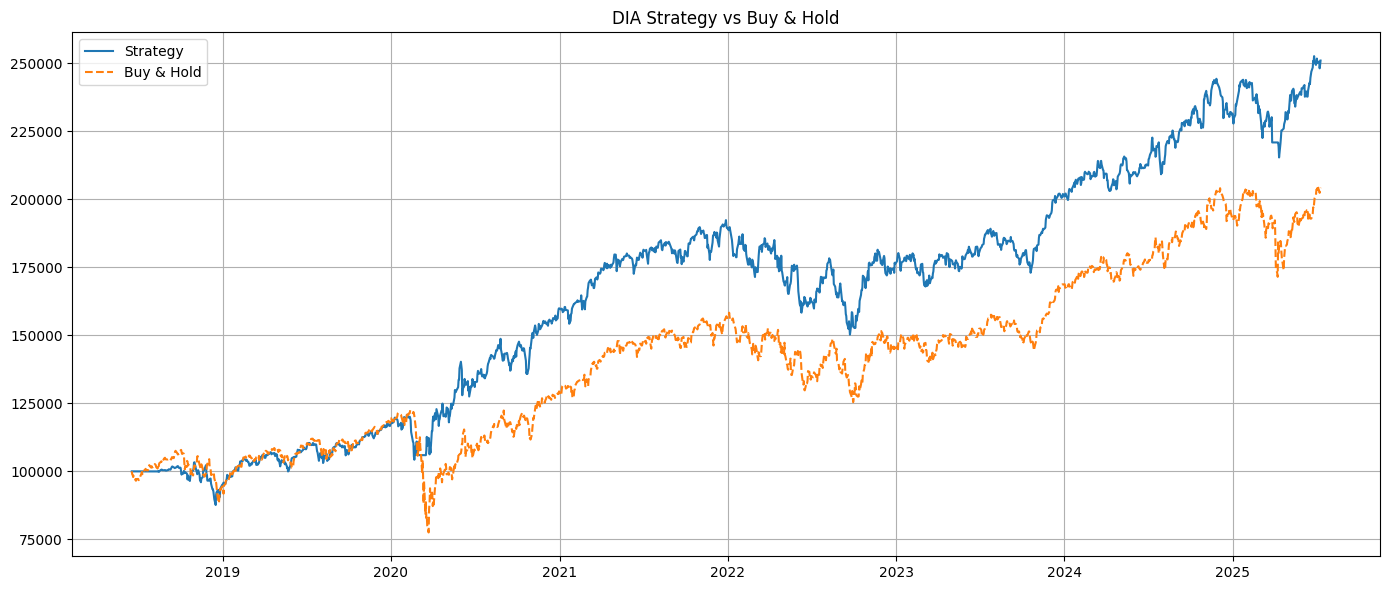


Processing IWM...


/tmp/ipython-input-3-2996925691.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-3-2996925691.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-3-2996925691.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.29 | CAGR: 4.21% | MaxDD: -44.58% | Calmar: 0.09 | Trades: 214


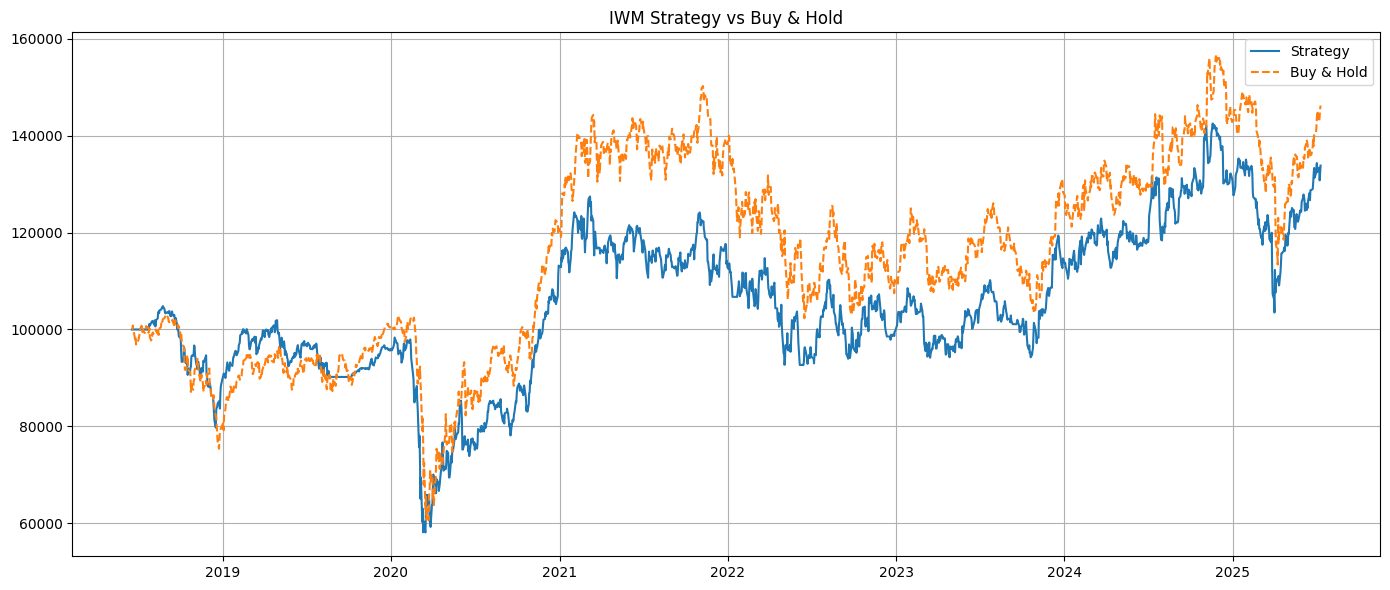


Processing VTI...


/tmp/ipython-input-3-2996925691.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-3-2996925691.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-3-2996925691.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.82 | CAGR: 13.69% | MaxDD: -26.70% | Calmar: 0.51 | Trades: 108


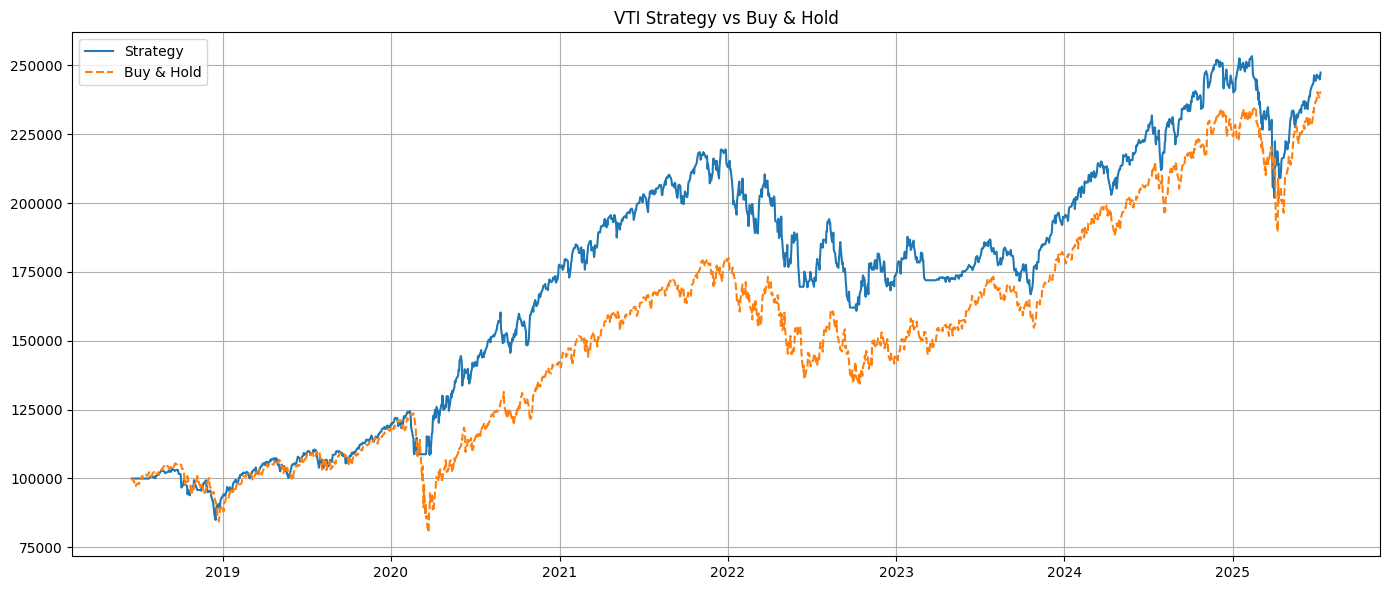

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# === Helper Indicators ===
def SMA(s, w): return s.rolling(w).mean()
def Momentum(s, p=10): return s - s.shift(p)
def ROC(s, n=10): return s.pct_change(n)
def RSI(s, p=14):
    delta = s.diff()
    gain, loss = delta.clip(lower=0), -delta.clip(upper=0)
    avg_gain = gain.rolling(p).mean()
    avg_loss = loss.rolling(p).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def MACD(s, f=12, sl=26, sig=9):
    ema1, ema2 = s.ewm(span=f, adjust=False).mean(), s.ewm(span=sl, adjust=False).mean()
    macd = ema1 - ema2
    return macd, macd.ewm(span=sig, adjust=False).mean()
def Bollinger(s, w=20, n=2):
    ma = s.rolling(w).mean()
    std = s.rolling(w).std()
    return ma + n * std, ma - n * std

# === Features ===
def compute_features(df):
    df['SMA20'] = SMA(df['Close'], 20)
    df['SMA50'] = SMA(df['Close'], 50)
    df['Momentum'] = Momentum(df['Close'], 10)
    df['RSI'] = RSI(df['Close'], 14)
    df['MACD'], df['MACD_sig'] = MACD(df['Close'])
    df['BB_up'], df['BB_low'] = Bollinger(df['Close'])
    df['Volatility'] = df['Close'].rolling(10).std()
    df['ROC'] = ROC(df['Close'], 5)
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    return df.dropna()

# === ML Training and Prediction ===
def rolling_train_predict(df, retrain_period=180):
    features = ['SMA20', 'SMA50', 'Momentum', 'RSI', 'MACD', 'MACD_sig',
                'BB_up', 'BB_low', 'Volatility', 'ROC']
    df['Prediction'] = np.nan
    df['Prediction_Prob'] = np.nan
    for start in range(0, len(df) - retrain_period, retrain_period):
        train = df.iloc[start:start+retrain_period]
        test = df.iloc[start+retrain_period:start+2*retrain_period]
        if len(test) == 0 or train['Target'].nunique() < 2:
            continue
        model = lgb.LGBMClassifier(n_estimators=100, verbosity=-1)
        model.fit(train[features], train['Target'])
        pred = model.predict(test[features])
        prob = model.predict_proba(test[features])[:, 1]
        df.loc[test.index, 'Prediction'] = pred
        df.loc[test.index, 'Prediction_Prob'] = prob
    return df.dropna()

# === Backtest Logic ===
def backtest(df, initial_cash=100000, transaction_cost=0.0005, base_frac=0.3, trail_stop_pct=0.08):
    cash = initial_cash
    position = 0
    portfolio_values = []
    trades = []
    entry_price = 0
    peak_price = 0
    recent_exit = False

    for i in range(5, len(df)):
        price = df['Close'].iloc[i]
        pred = df['Prediction'].iloc[i]
        prob = df['Prediction_Prob'].iloc[i]
        rsi = df['RSI'].iloc[i]
        vol = df['Volatility'].iloc[i]
        sma20 = df['SMA20'].iloc[i]
        sma50 = df['SMA50'].iloc[i]

        recent_avg_vol = df['Volatility'].rolling(30).mean().iloc[i]
        if pd.isna(recent_avg_vol) or vol > recent_avg_vol * 1.5:
            portfolio_values.append(cash + position * price)
            continue

        if position > 0:
            peak_price = max(peak_price, price)
            if price < peak_price * (1 - trail_stop_pct):
                proceeds = position * price * (1 - transaction_cost)
                cash += proceeds
                trades.append((df.index[i], 'Trailing_Stop', position, price))
                position = 0
                recent_exit = True
                portfolio_values.append(cash)
                continue

        trend_strength = sma50 - df['SMA50'].iloc[i - 5]
        allow_rsi = 70 if trend_strength > 0 else 60
        exit_prob_thresh = 0.45 if trend_strength > 0 else 0.5

        enter_long = (pred == 1) and (prob > 0.52) and (rsi < 65)
        exit_long = (pred == 0) and (prob < exit_prob_thresh) and (rsi > allow_rsi) and (price < sma20)

        if enter_long and cash > price:
            dynamic_frac = base_frac + (prob - 0.5) * 0.8
            shares_to_buy = int((cash * dynamic_frac) // price)
            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + transaction_cost)
                cash -= cost
                position += shares_to_buy
                entry_price = price
                peak_price = price
                trades.append((df.index[i], 'Buy', shares_to_buy, price))
                recent_exit = False

        elif enter_long and recent_exit and price > entry_price * 1.02:
            dynamic_frac = base_frac + (prob - 0.5) * 0.8
            shares_to_buy = int((cash * dynamic_frac) // price)
            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + transaction_cost)
                cash -= cost
                position += shares_to_buy
                entry_price = price
                peak_price = price
                trades.append((df.index[i], 'ReBuy', shares_to_buy, price))
                recent_exit = False

        elif exit_long and position > 0:
            shares_to_sell = int(position * (0.5 + (0.5 - abs(prob - 0.5)) * 0.5))
            if shares_to_sell > 0:
                proceeds = shares_to_sell * price * (1 - transaction_cost)
                cash += proceeds
                position -= shares_to_sell
                trades.append((df.index[i], 'Sell', shares_to_sell, price))
                recent_exit = True

        total_value = cash + position * price
        portfolio_values.append(total_value)

    df = df.iloc[:len(portfolio_values)].copy()
    df['Strategy'] = portfolio_values
    df['BuyHold'] = initial_cash * df['Close'] / df['Close'].iloc[0]
    df['Daily_Return'] = df['Strategy'].pct_change().fillna(0)
    return df, trades

# === Metrics ===
def compute_sharpe(df): return (df['Daily_Return'].mean() / df['Daily_Return'].std()) * np.sqrt(252)
def compute_cagr(df):
    years = (df.index[-1] - df.index[0]).days / 365.25
    return (df['Strategy'].iloc[-1] / df['Strategy'].iloc[0]) ** (1 / years) - 1
def compute_max_drawdown(df):
    peak = df['Strategy'].cummax()
    dd = (df['Strategy'] - peak) / peak
    return dd.min()
def compute_calmar(df):
    dd = abs(compute_max_drawdown(df))
    return compute_cagr(df) / dd if dd > 0 else np.nan

# === Plotting ===
def plot_results(df, trades, ticker):
    plt.figure(figsize=(14,6))
    plt.plot(df.index, df['Strategy'], label='Strategy')
    plt.plot(df.index, df['BuyHold'], '--', label='Buy & Hold')
    plt.title(f'{ticker} Strategy vs Buy & Hold')
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# === Main Run ===
tickers = ['SPY', 'QQQ', 'DIA', 'IWM', 'VTI']
end = datetime.today()
start = end - timedelta(days=8*365)

for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), progress=False, auto_adjust=True)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df = compute_features(df[['Close']])
    df = rolling_train_predict(df)
    df, trades = backtest(df)
    sharpe, cagr = compute_sharpe(df), compute_cagr(df)
    max_dd, calmar = compute_max_drawdown(df), compute_calmar(df)
    print(f"Sharpe: {sharpe:.2f} | CAGR: {cagr:.2%} | MaxDD: {max_dd:.2%} | Calmar: {calmar:.2f} | Trades: {len(trades)}")
    plot_results(df, trades, ticker)



Processing SPY...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.71 | CAGR: 12.78% | MaxDD: -33.72% | Calmar: 0.38 | Trades: 140


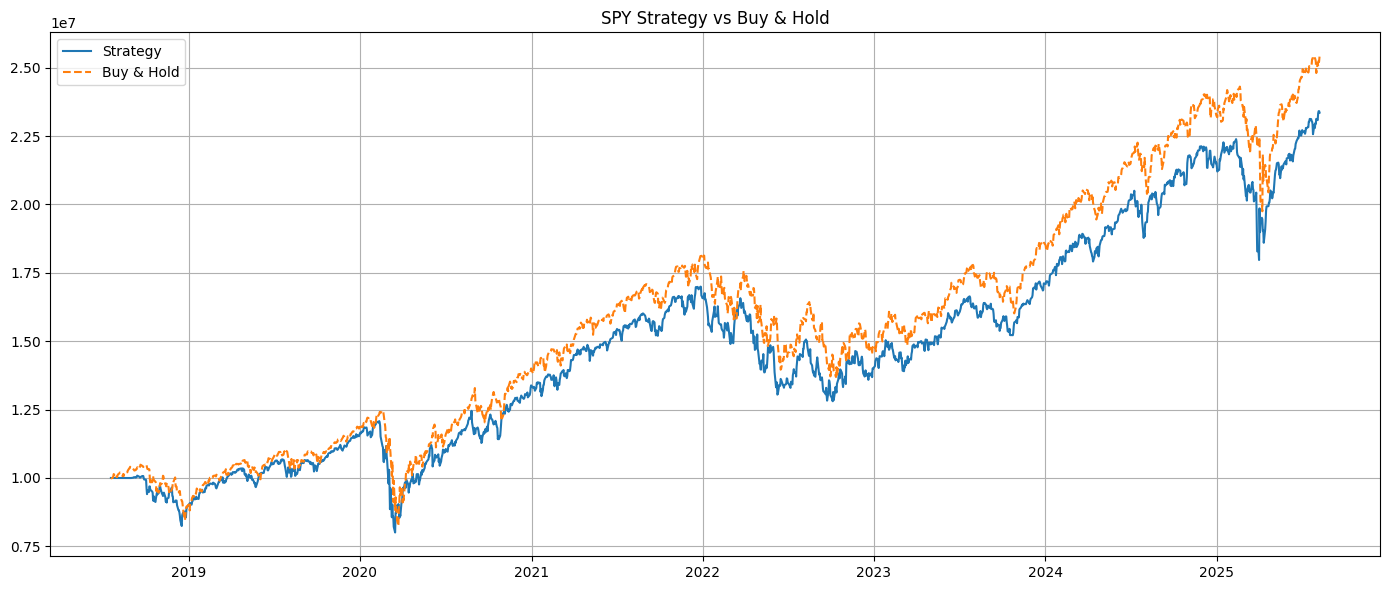


Processing QQQ...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.70 | CAGR: 14.58% | MaxDD: -35.29% | Calmar: 0.41 | Trades: 226


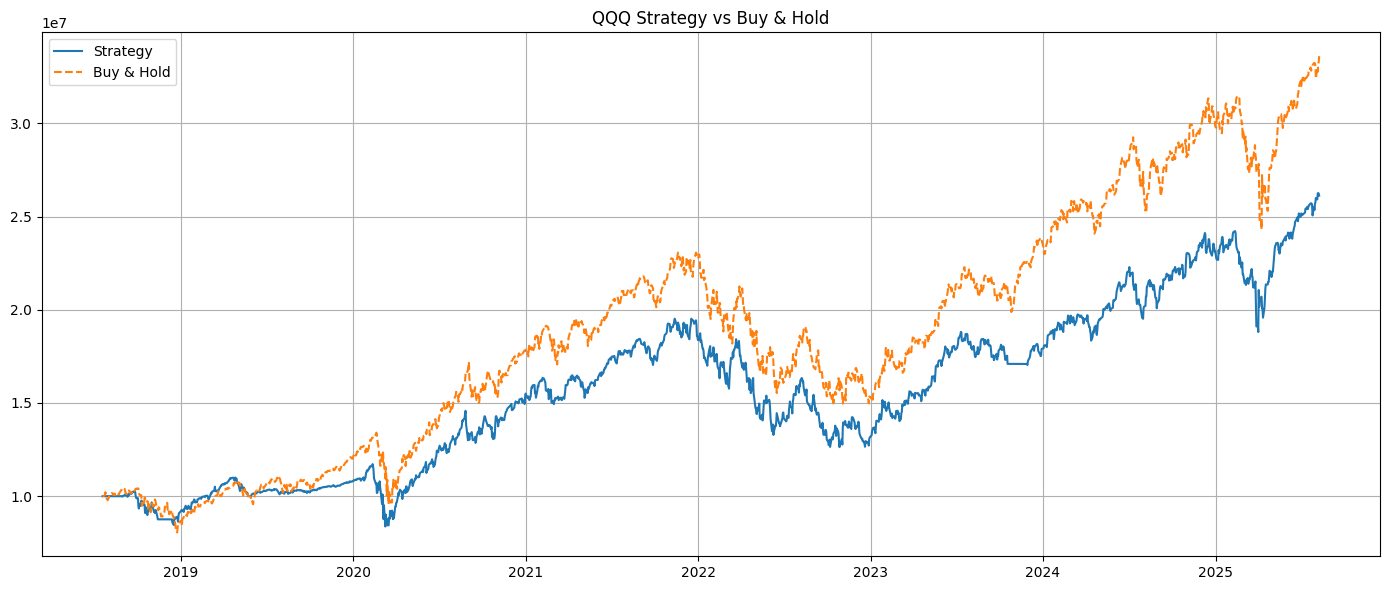


Processing IWM...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.26 | CAGR: 3.47% | MaxDD: -43.37% | Calmar: 0.08 | Trades: 261


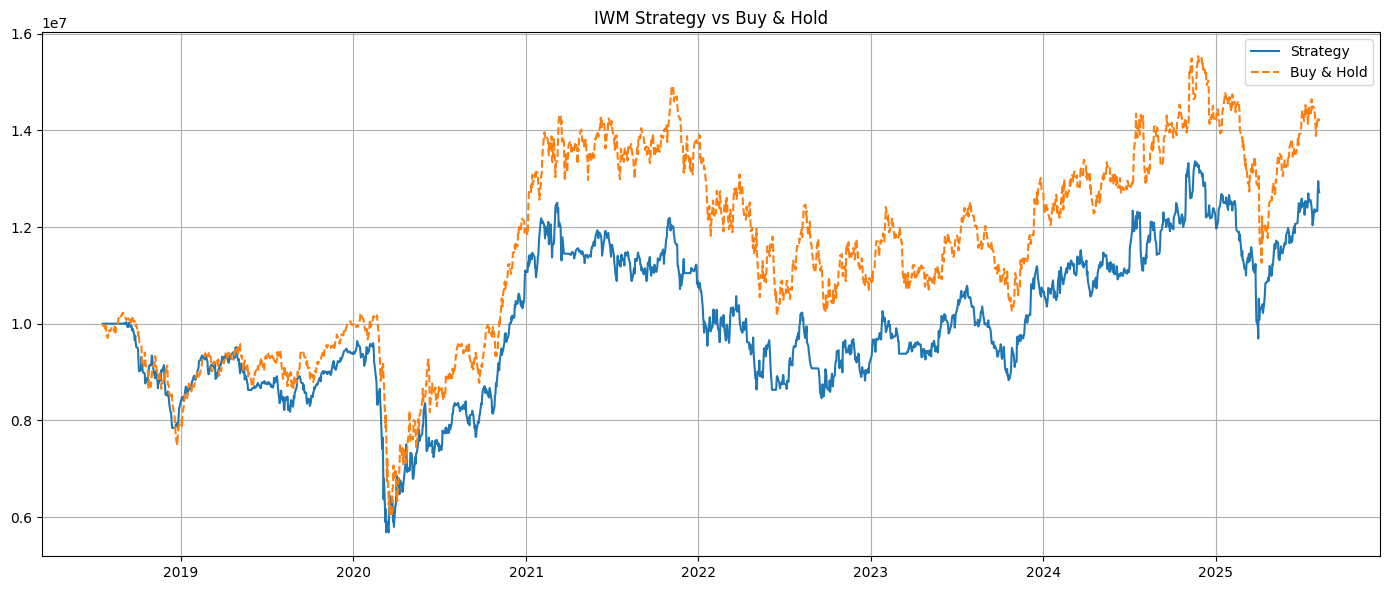


Processing DIA...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.95 | CAGR: 14.76% | MaxDD: -19.82% | Calmar: 0.74 | Trades: 93


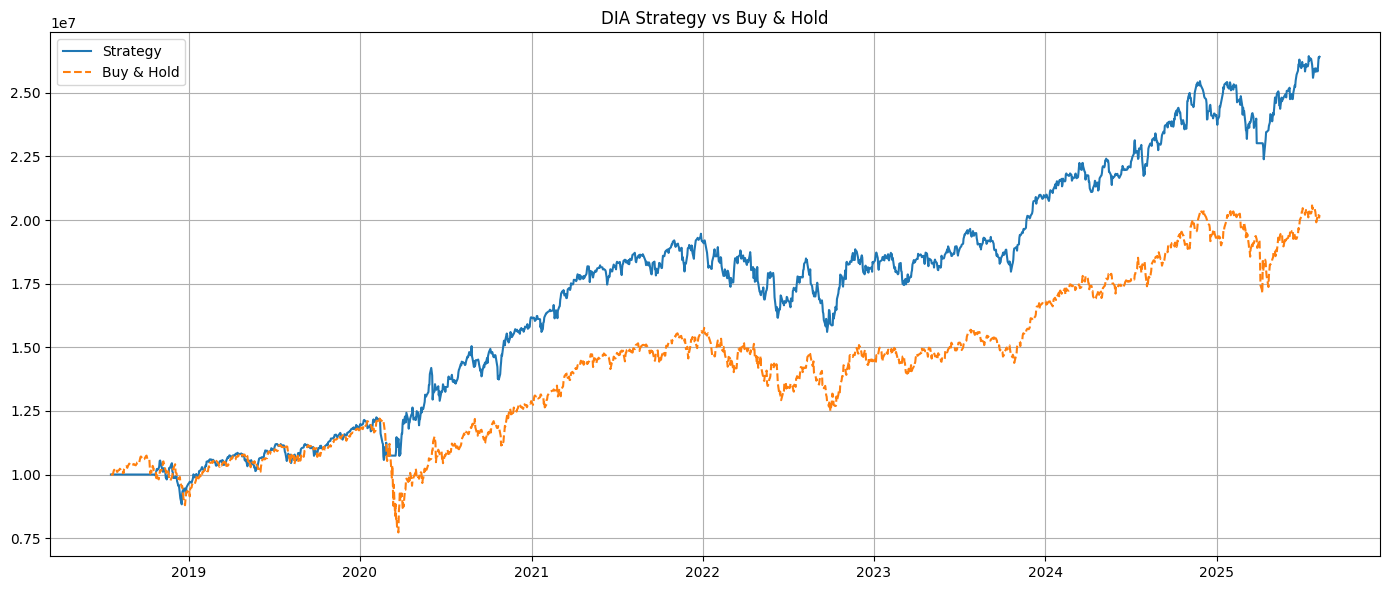


Processing XLF...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.52 | CAGR: 9.60% | MaxDD: -40.97% | Calmar: 0.23 | Trades: 194


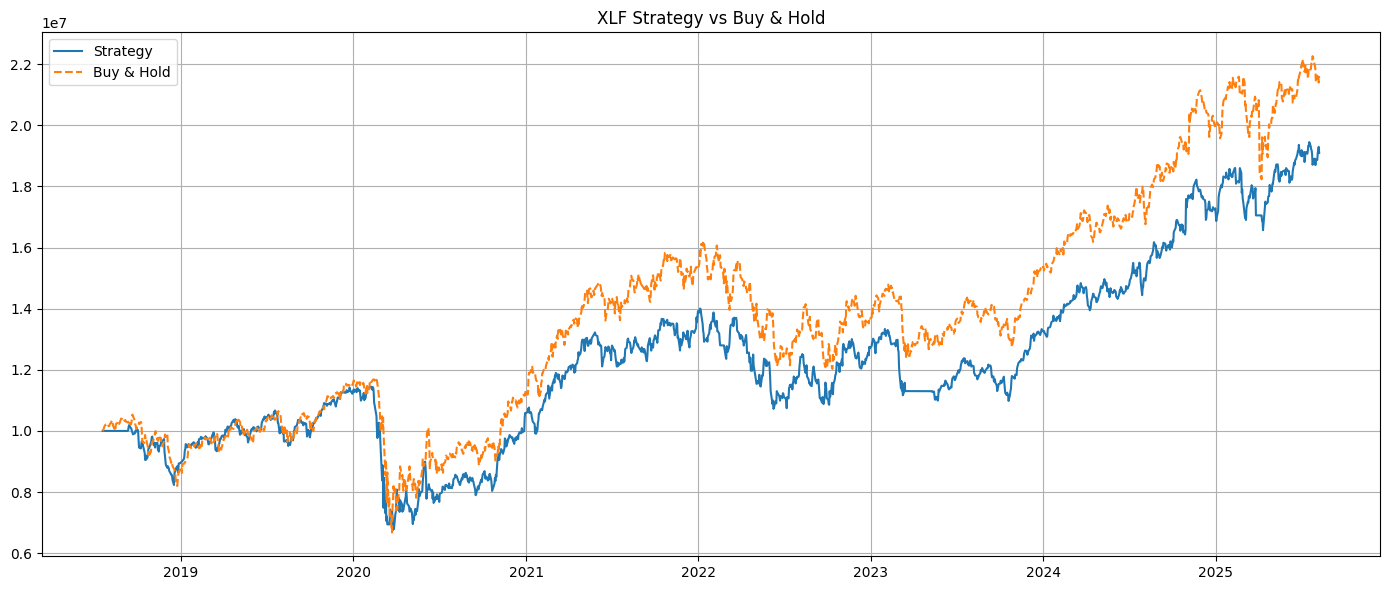


Processing XLK...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.87 | CAGR: 20.90% | MaxDD: -28.71% | Calmar: 0.73 | Trades: 241


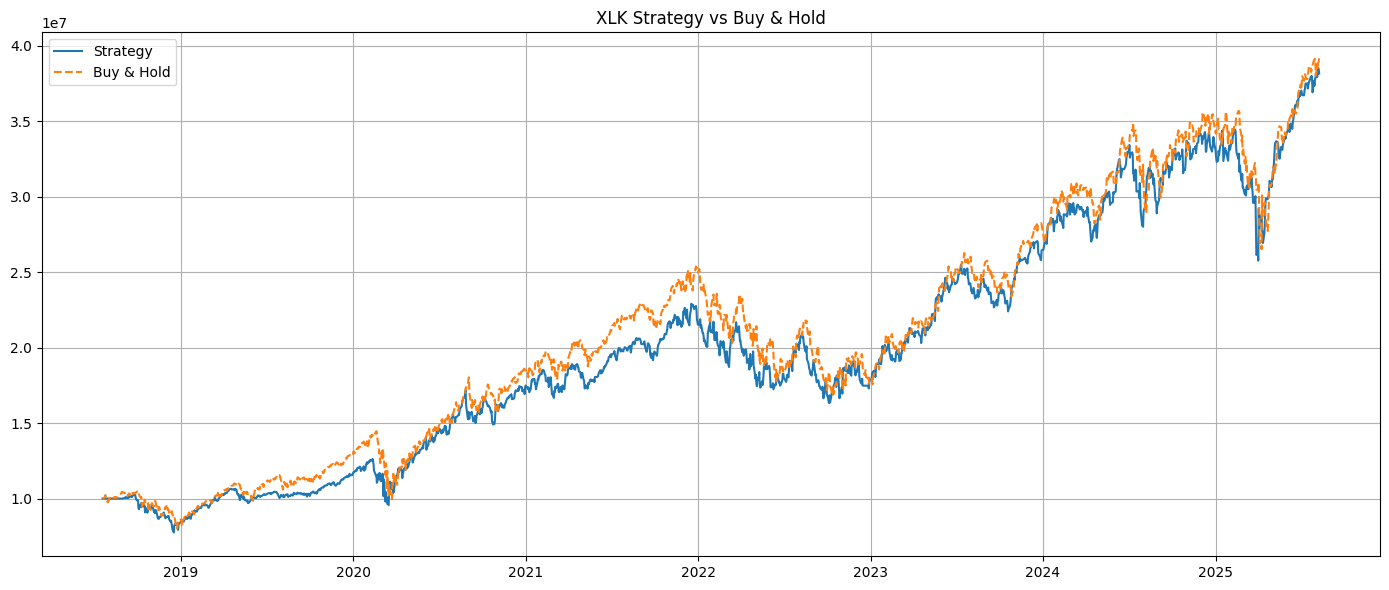


Processing XLE...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.39 | CAGR: 7.04% | MaxDD: -45.17% | Calmar: 0.16 | Trades: 335


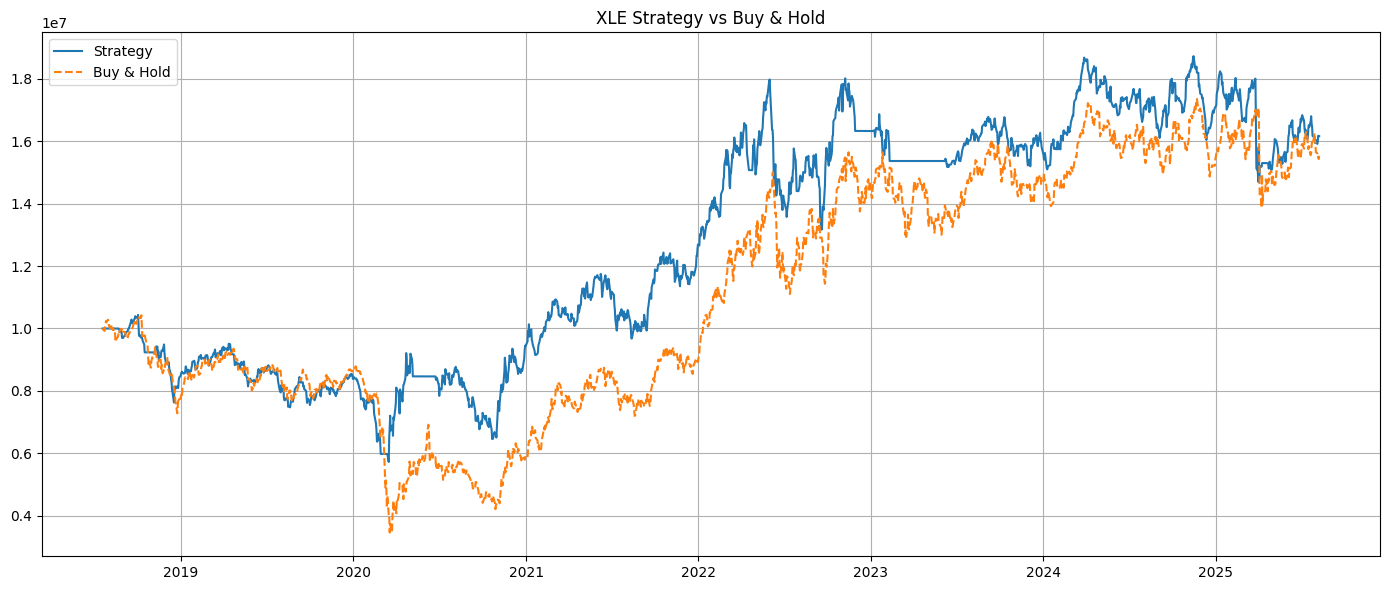


Processing XLV...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.49 | CAGR: 7.00% | MaxDD: -28.15% | Calmar: 0.25 | Trades: 139


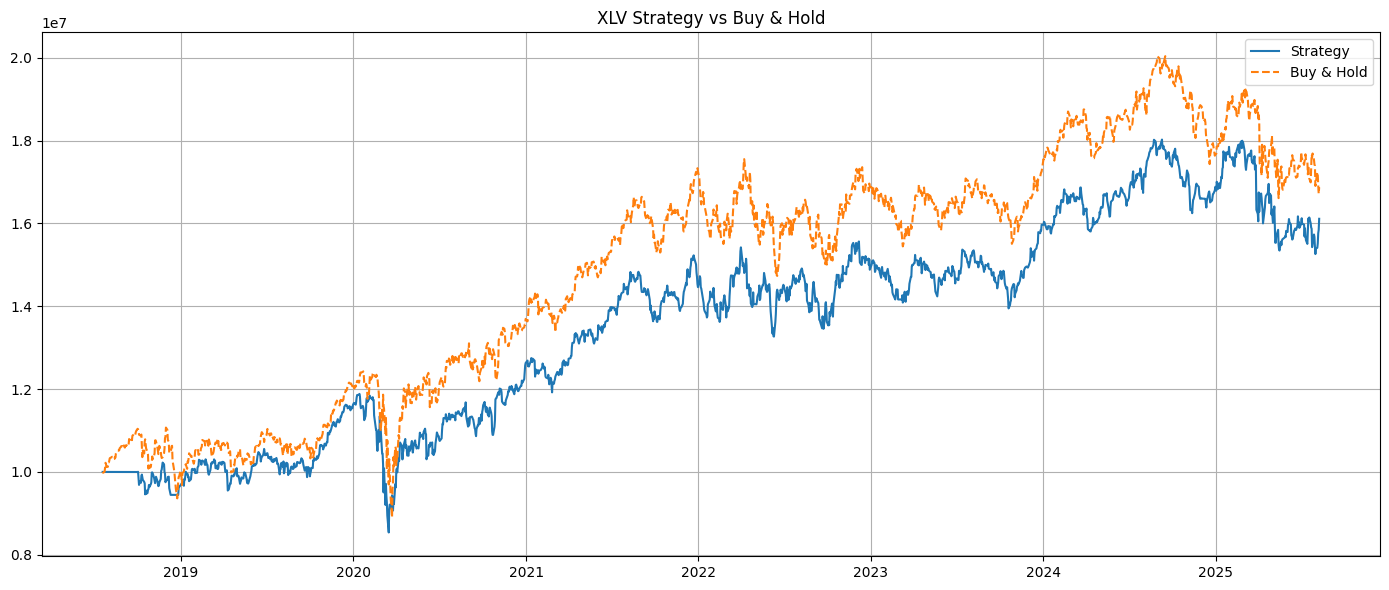


Processing XLY...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.47 | CAGR: 8.00% | MaxDD: -43.40% | Calmar: 0.18 | Trades: 270


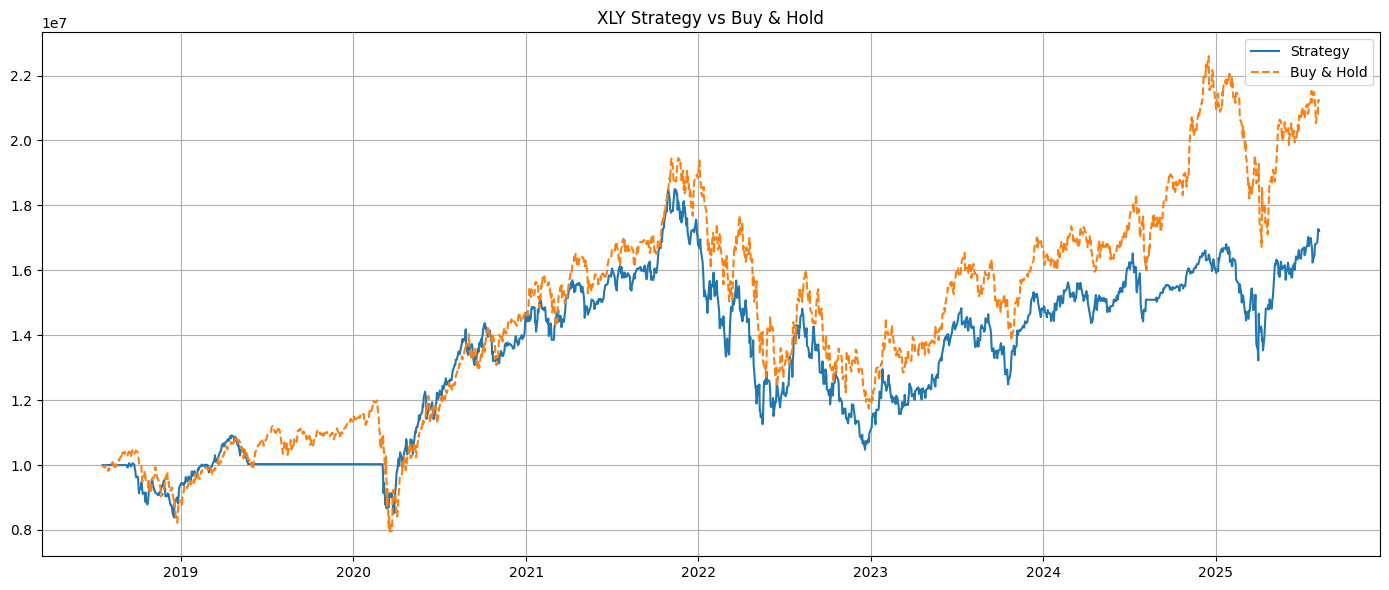


Processing XLP...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.58 | CAGR: 8.14% | MaxDD: -24.51% | Calmar: 0.33 | Trades: 103


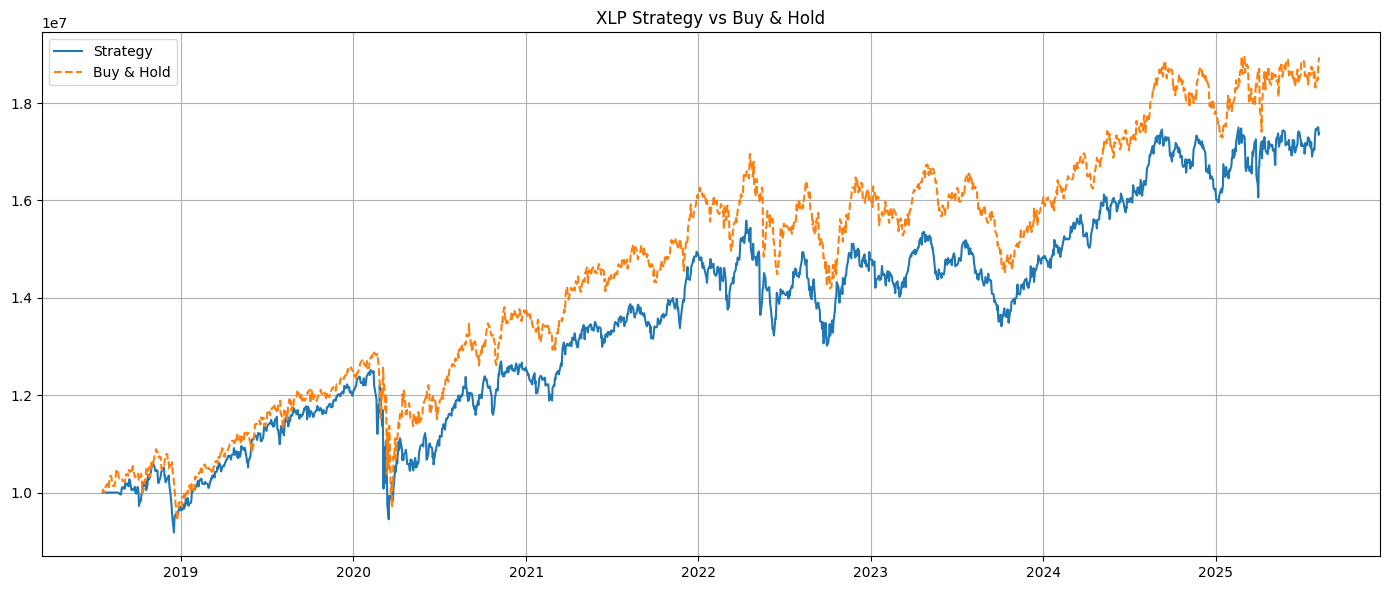


Processing XLI...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.53 | CAGR: 9.40% | MaxDD: -42.33% | Calmar: 0.22 | Trades: 186


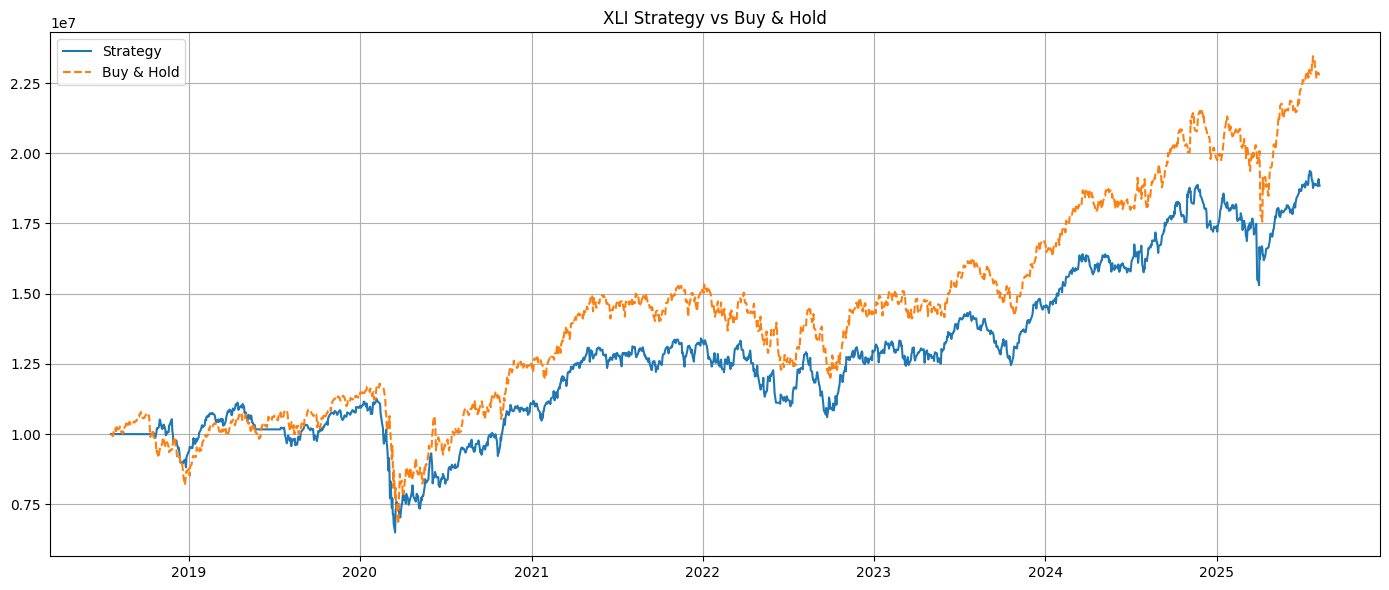


Processing XLU...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.47 | CAGR: 7.73% | MaxDD: -36.07% | Calmar: 0.21 | Trades: 193


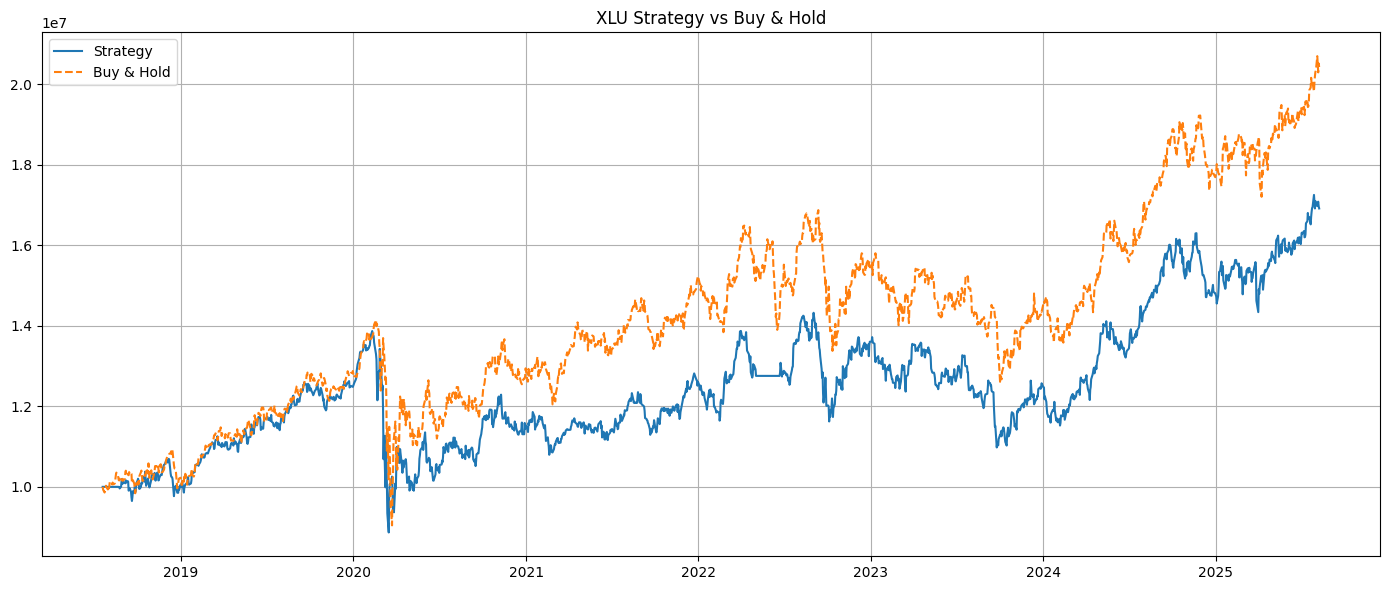


Processing ARKK...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.39 | CAGR: 7.62% | MaxDD: -74.35% | Calmar: 0.10 | Trades: 453


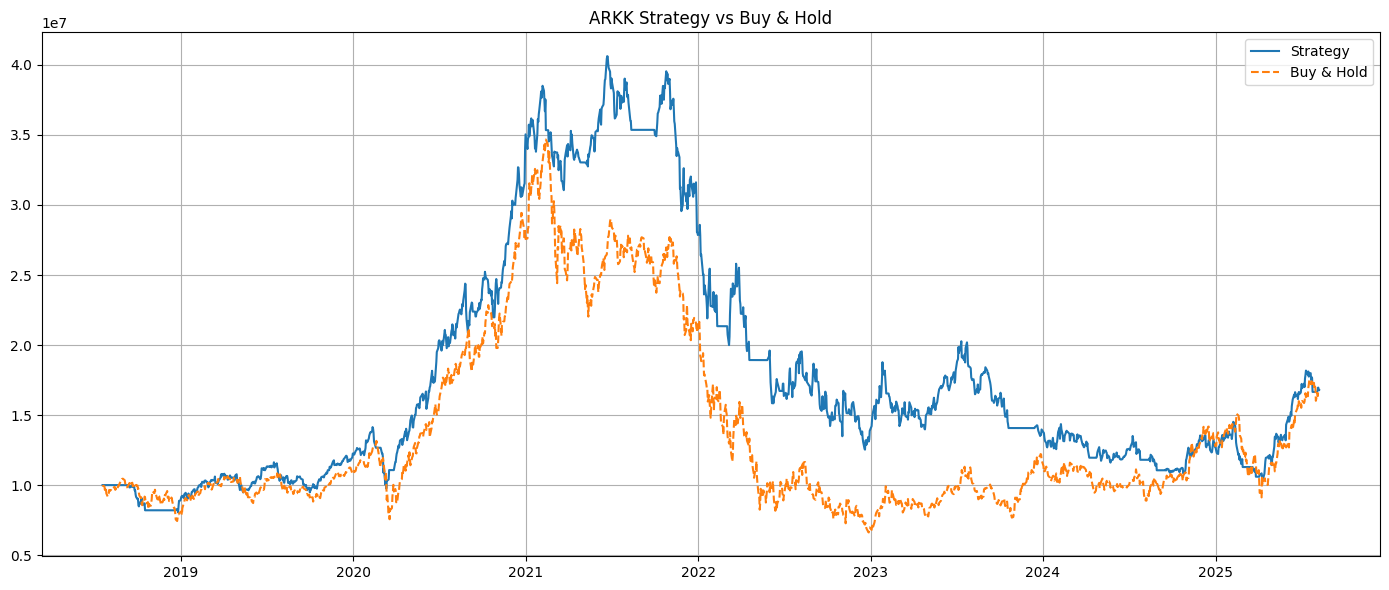


Processing TLT...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 0.13 | CAGR: 0.83% | MaxDD: -33.44% | Calmar: 0.02 | Trades: 186


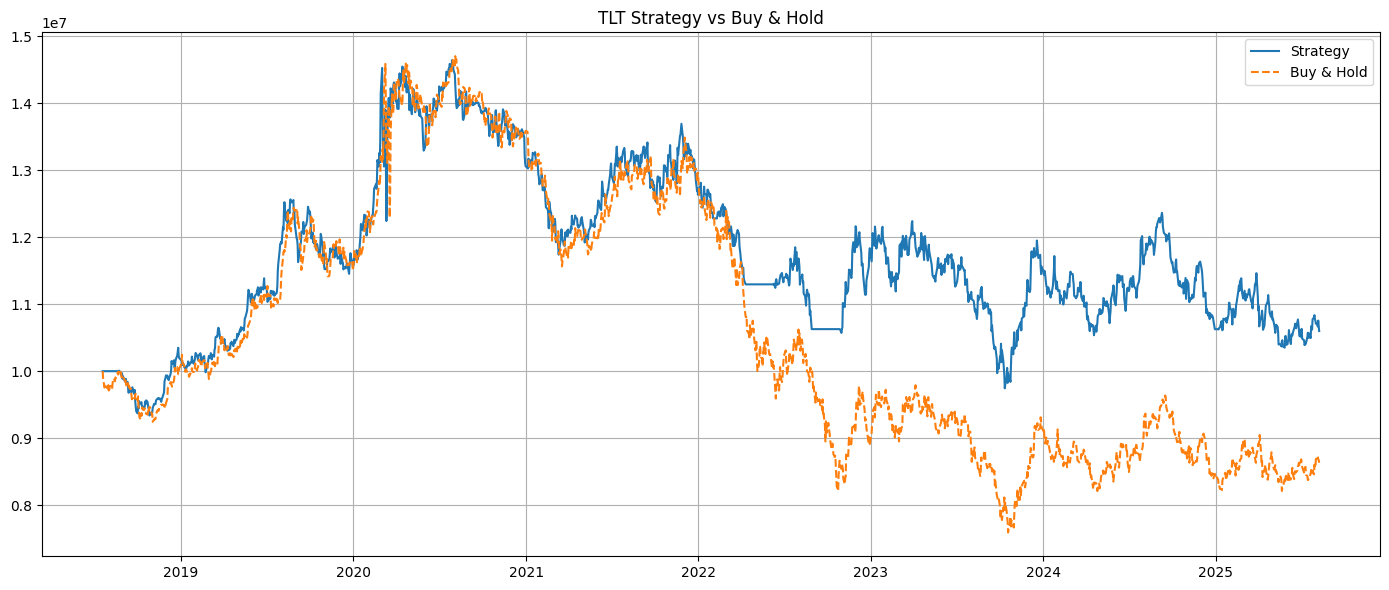


Processing GLD...


/tmp/ipython-input-1708838748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-1708838748.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-1708838748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sharpe: 1.01 | CAGR: 14.81% | MaxDD: -23.39% | Calmar: 0.63 | Trades: 122


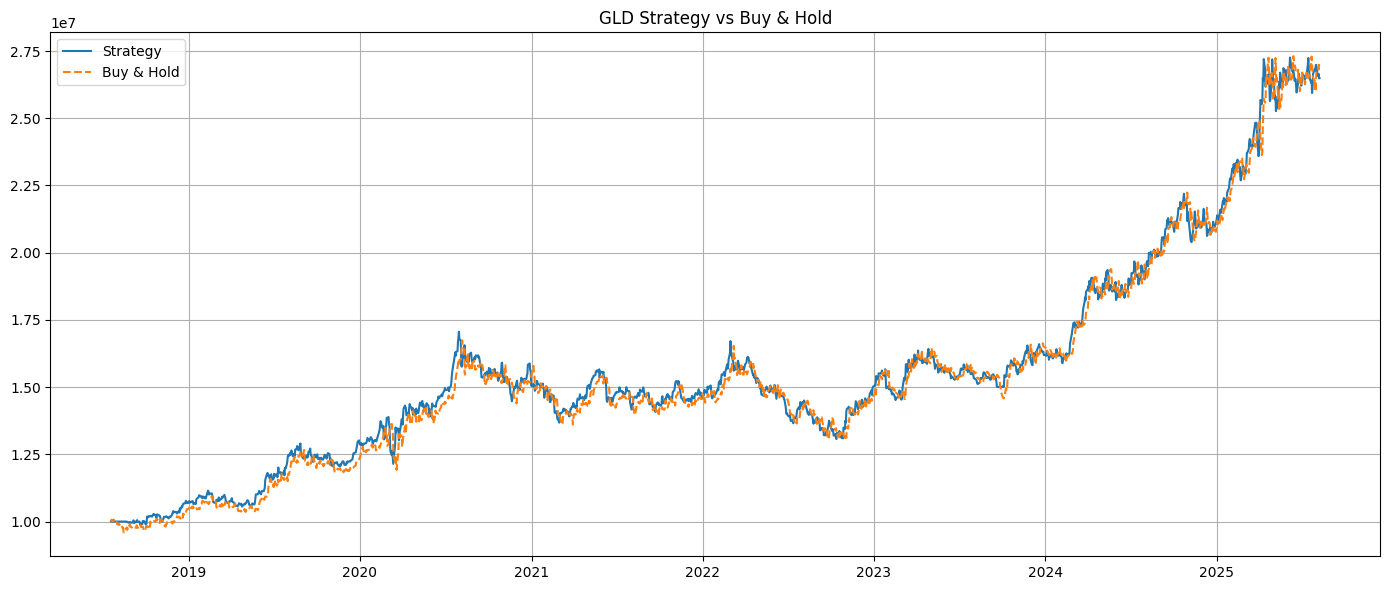

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# === Indicators ===
def SMA(s, w): return s.rolling(w).mean()
def Momentum(s, p=10): return s - s.shift(p)
def ROC(s, n=10): return s.pct_change(n)
def RSI(s, p=14):
    delta = s.diff()
    gain, loss = delta.clip(lower=0), -delta.clip(upper=0)
    avg_gain, avg_loss = gain.rolling(p).mean(), loss.rolling(p).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def MACD(s, f=12, sl=26, sig=9):
    ema1, ema2 = s.ewm(span=f, adjust=False).mean(), s.ewm(span=sl, adjust=False).mean()
    macd = ema1 - ema2
    return macd, macd.ewm(span=sig, adjust=False).mean()
def Bollinger(s, w=20, n=2):
    ma, std = s.rolling(w).mean(), s.rolling(w).std()
    return ma + n * std, ma - n * std

# === Feature Engineering ===
def compute_features(df):
    df['SMA20'] = SMA(df['Close'], 20)
    df['SMA50'] = SMA(df['Close'], 50)
    df['Momentum'] = Momentum(df['Close'], 10)
    df['RSI'] = RSI(df['Close'], 14)
    df['MACD'], df['MACD_sig'] = MACD(df['Close'])
    df['BB_up'], df['BB_low'] = Bollinger(df['Close'])
    df['Volatility'] = df['Close'].rolling(10).std()
    df['ROC'] = ROC(df['Close'], 5)
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    return df.dropna()

# === Rolling ML Training ===
def rolling_train_predict(df, retrain_period=180):
    features = ['SMA20','SMA50','Momentum','RSI','MACD','MACD_sig',
                'BB_up','BB_low','Volatility','ROC']
    df['Prediction'], df['Prediction_Prob'] = np.nan, np.nan
    for start in range(0, len(df) - retrain_period, retrain_period):
        train, test = df.iloc[start:start+retrain_period], df.iloc[start+retrain_period:start+2*retrain_period]
        if len(test) == 0 or train['Target'].nunique() < 2: continue
        model = lgb.LGBMClassifier(n_estimators=100, verbosity=-1)
        model.fit(train[features], train['Target'])
        df.loc[test.index, 'Prediction'] = model.predict(test[features])
        df.loc[test.index, 'Prediction_Prob'] = model.predict_proba(test[features])[:,1]
    return df.dropna()

# === Backtest with Cash Reserve + Memory + Quick Exit ===
def backtest(df, initial_cash=10000000, transaction_cost=0.0005, base_frac=0.3,
             trail_stop_pct=0.08, memory_window=5, cash_reserve=0.95):
    cash, position, entry_price, peak_price = initial_cash, 0, 0, 0
    portfolio_values, trades, memory = [], [], []
    recent_exit = False

    for i in range(5, len(df)):
        price, pred, prob, rsi = df['Close'].iloc[i], df['Prediction'].iloc[i], df['Prediction_Prob'].iloc[i], df['RSI'].iloc[i]
        sma20, sma50, vol = df['SMA20'].iloc[i], df['SMA50'].iloc[i], df['Volatility'].iloc[i]
        recent_avg_vol = df['Volatility'].rolling(30).mean().iloc[i]

        # High volatility filter
        if pd.isna(recent_avg_vol) or vol > recent_avg_vol * 1.5:
            portfolio_values.append(cash + position * price); continue

        # Memory (avoid whipsaws)
        memory.append(pred if pred in [0,1] else 0)
        if len(memory) > memory_window: memory.pop(0)
        voted_signal = 1 if sum(memory) > len(memory)//2 else 0

        # Trailing Stop
        if position > 0:
            peak_price = max(peak_price, price)
            if price < peak_price * (1 - trail_stop_pct):
                cash += position * price * (1 - transaction_cost)
                trades.append((df.index[i], 'Trailing_Stop', position, price))
                position, recent_exit = 0, True
                portfolio_values.append(cash); continue

        # Trend detection
        trend_strength = sma50 - df['SMA50'].iloc[i-5]
        exit_prob_thresh = 0.45 if trend_strength > 0 else 0.5
        allow_rsi = 70 if trend_strength > 0 else 60

        enter_long = (voted_signal==1) and (prob>0.52) and (rsi<65)
        exit_long  = (voted_signal==0) and (prob<exit_prob_thresh) and (rsi>allow_rsi) and (price<sma20)

        # Enter long
        if enter_long and cash > price:
            dynamic_frac = min(base_frac + (prob - 0.5) * 0.8, cash_reserve)
            shares_to_buy = int((cash * dynamic_frac) // price)
            if shares_to_buy > 0:
                cash -= shares_to_buy * price * (1 + transaction_cost)
                position += shares_to_buy
                entry_price, peak_price, recent_exit = price, price, False
                trades.append((df.index[i], 'Buy', shares_to_buy, price))

        # Re-enter after exit
        elif enter_long and recent_exit and price > entry_price*1.02:
            dynamic_frac = min(base_frac + (prob - 0.5) * 0.8, cash_reserve)
            shares_to_buy = int((cash * dynamic_frac) // price)
            if shares_to_buy > 0:
                cash -= shares_to_buy * price * (1 + transaction_cost)
                position += shares_to_buy
                entry_price, peak_price, recent_exit = price, price, False
                trades.append((df.index[i], 'ReBuy', shares_to_buy, price))

        # Exit long
        elif exit_long and position > 0:
            shares_to_sell = int(position * (0.5 + (0.5 - abs(prob-0.5))*0.5))
            if shares_to_sell > 0:
                cash += shares_to_sell * price * (1 - transaction_cost)
                position -= shares_to_sell
                trades.append((df.index[i], 'Sell', shares_to_sell, price))
                recent_exit = True

        portfolio_values.append(cash + position * price)

    df = df.iloc[:len(portfolio_values)].copy()
    df['Strategy'] = portfolio_values
    df['BuyHold'] = initial_cash * df['Close'] / df['Close'].iloc[0]
    df['Daily_Return'] = df['Strategy'].pct_change().fillna(0)
    return df, trades

# === Metrics ===
def compute_sharpe(df): return (df['Daily_Return'].mean()/df['Daily_Return'].std())*np.sqrt(252)
def compute_cagr(df):
    years = (df.index[-1]-df.index[0]).days/365.25
    return (df['Strategy'].iloc[-1]/df['Strategy'].iloc[0])**(1/years)-1
def compute_max_drawdown(df):
    peak=df['Strategy'].cummax(); dd=(df['Strategy']-peak)/peak; return dd.min()
def compute_calmar(df):
    dd=abs(compute_max_drawdown(df)); return compute_cagr(df)/dd if dd>0 else np.nan

# === Plotting ===
def plot_results(df, trades, ticker):
    plt.figure(figsize=(14,6))
    plt.plot(df.index, df['Strategy'], label='Strategy')
    plt.plot(df.index, df['BuyHold'], '--', label='Buy & Hold')
    plt.title(f'{ticker} Strategy vs Buy & Hold')
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# === Main Run ===
tickers = [
    "SPY",   # S&P 500 ETF
    "QQQ",   # Nasdaq 100 ETF
    "IWM",   # Russell 2000 ETF
    "DIA",   # Dow Jones ETF
    "XLF",   # Financials sector ETF
    "XLK",   # Technology sector ETF
    "XLE",   # Energy sector ETF
    "XLV",   # Healthcare sector ETF
    "XLY",   # Consumer Discretionary sector ETF
    "XLP",   # Consumer Staples sector ETF
    "XLI",   # Industrials sector ETF
    "XLU",   # Utilities sector ETF
    "ARKK",  # ARK Innovation ETF (growth/innovation)
    "TLT",   # 20+ Year Treasury Bond ETF (bonds/hedge)
    "GLD"    # Gold ETF (safe haven asset)
]

end, start = datetime.today(), datetime.today()-timedelta(days=8*365)

for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), progress=False, auto_adjust=True)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df = compute_features(df[['Close']])
    df = rolling_train_predict(df)
    df, trades = backtest(df)
    sharpe, cagr = compute_sharpe(df), compute_cagr(df)
    max_dd, calmar = compute_max_drawdown(df), compute_calmar(df)
    print(f"Sharpe: {sharpe:.2f} | CAGR: {cagr:.2%} | MaxDD: {max_dd:.2%} | Calmar: {calmar:.2f} | Trades: {len(trades)}")
    plot_results(df, trades, ticker)


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ===============================
# Parameters
# ===============================
TICKERS = ["SPY", "QQQ", "IWM", "DIA", "XLK", "XLF", "XLE", "XLV", "XLU", "XLY"]
START = "2010-01-01"
END = "2025-01-01"
SEEDS = (7, 19, 37)

# ===============================
# Feature Engineering
# ===============================
def compute_features(df):
    df["Return"] = df["Adj Close"].pct_change()
    df["FwdRet1"] = df["Return"].shift(-1)

    # Rolling stats
    df["Vol20"] = df["Return"].rolling(20).std()
    df["MA10"] = df["Adj Close"].rolling(10).mean()
    df["MA50"] = df["Adj Close"].rolling(50).mean()
    df["MA200"] = df["Adj Close"].rolling(200).mean()

    # Momentum
    df["RSI14"] = compute_rsi(df["Adj Close"], 14)

    # Trend indicator
    df["Trend"] = np.where(df["MA50"] > df["MA200"], 1, -1)

    df = df.dropna()
    return df

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window).mean()
    avg_loss = pd.Series(loss).rolling(window).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    return 100 - (100 / (1 + rs))

# ===============================
# Rolling Walk-Forward Training
# ===============================
def rolling_train_predict(df, retrain_period=240, step=60, val_frac=0.2, seeds=SEEDS):
    X_cols = ["Return", "Vol20", "MA10", "MA50", "MA200", "RSI14", "Trend"]
    df["Signal"] = 0
    df["Prob"] = np.nan

    for start in range(0, len(df) - retrain_period, step):
        end = start + retrain_period
        chunk = df.iloc[start:end].copy()

        if chunk.shape[0] < retrain_period:
            continue

        X = chunk[X_cols]
        y = (chunk["FwdRet1"] > 0).astype(int)

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=val_frac, shuffle=False
        )

        best_model, best_thr, best_score = None, 0.5, -np.inf

        for seed in seeds:
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("gb", GradientBoostingClassifier(random_state=seed))
            ])
            pipe.fit(X_train, y_train)

            val_prob = pd.Series(pipe.predict_proba(X_val)[:, 1], index=y_val.index)
            for thr in np.linspace(0.4, 0.6, 9):
                sig = (val_prob > thr).astype(int)
                strat_ret = sig.shift(1).fillna(0) * df.loc[y_val.index, "FwdRet1"]
                score = strat_ret.mean() / (strat_ret.std() + 1e-9)  # Sharpe-like

                if score > best_score:
                    best_model, best_thr, best_score = pipe, thr, score

        # Apply to next step
        next_idx = df.iloc[end:end+step].index
        if len(next_idx) == 0 or best_model is None:
            continue

        probs = pd.Series(best_model.predict_proba(df.loc[next_idx, X_cols])[:, 1], index=next_idx)
        df.loc[next_idx, "Prob"] = probs
        df.loc[next_idx, "Signal"] = (probs > best_thr).astype(int)

    return df

# ===============================
# Backtest
# ===============================
def backtest(df):
    df["Position"] = 0
    df["Position"] = df["Signal"].shift(1).fillna(0)

    # Simple trend filter: cut exposure if 50MA < 200MA (downtrend)
    df.loc[df["MA50"] < df["MA200"], "Position"] = -0.5  # partial hedge

    df["StrategyRet"] = df["Position"] * df["FwdRet1"]
    df["Equity"] = (1 + df["StrategyRet"]).cumprod()
    df["BuyHold"] = (1 + df["FwdRet1"].fillna(0)).cumprod()
    return df

# ===============================
# Run
# ===============================
for ticker in TICKERS:
    print(f"Processing {ticker}...")
    df_raw = yf.download(ticker, start=START, end=END)
    if df_raw.empty:
        continue

    df = compute_features(df_raw)
    df = rolling_train_predict(df, retrain_period=240, step=60, val_frac=0.2, seeds=SEEDS)
    if df.empty:
        continue

    df = backtest(df)

    plt.figure(figsize=(12,6))
    plt.plot(df.index, df["BuyHold"], label="Buy & Hold", color="orange")
    plt.plot(df.index, df["Equity"], label="Strategy", color="blue")
    plt.title(f"{ticker} Strategy vs Buy & Hold")
    plt.legend()
    plt.show()



Processing SPY...


/tmp/ipython-input-2748914986.py:120: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download(ticker, start=START, end=END)
[*********************100%***********************]  1 of 1 completed


KeyError: 'Adj Close'


Processing ^BSESN...


/tmp/ipython-input-6-3996243062.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-6-3996243062.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-6-3996243062.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.75 | CAGR: 5.95% | MaxDD: -14.71% | Calmar: 0.40 | Trades: 185


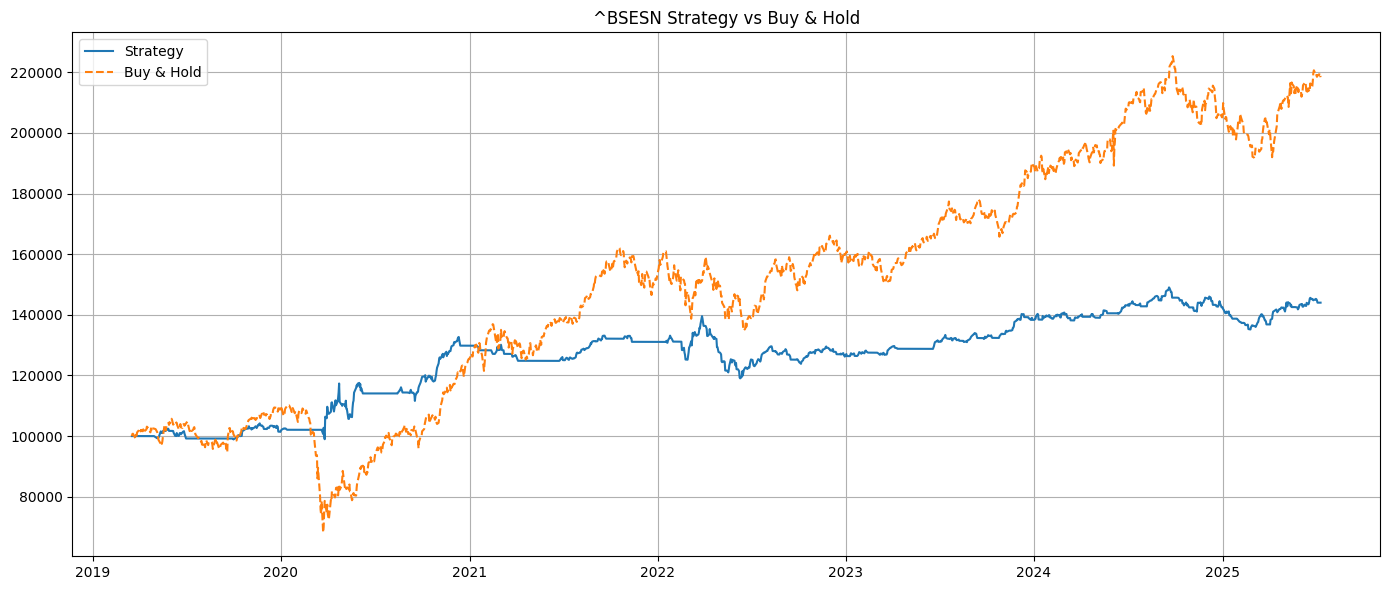


Processing RELIANCE.NS...


/tmp/ipython-input-6-3996243062.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-6-3996243062.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-6-3996243062.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.75 | CAGR: 14.17% | MaxDD: -29.21% | Calmar: 0.48 | Trades: 319


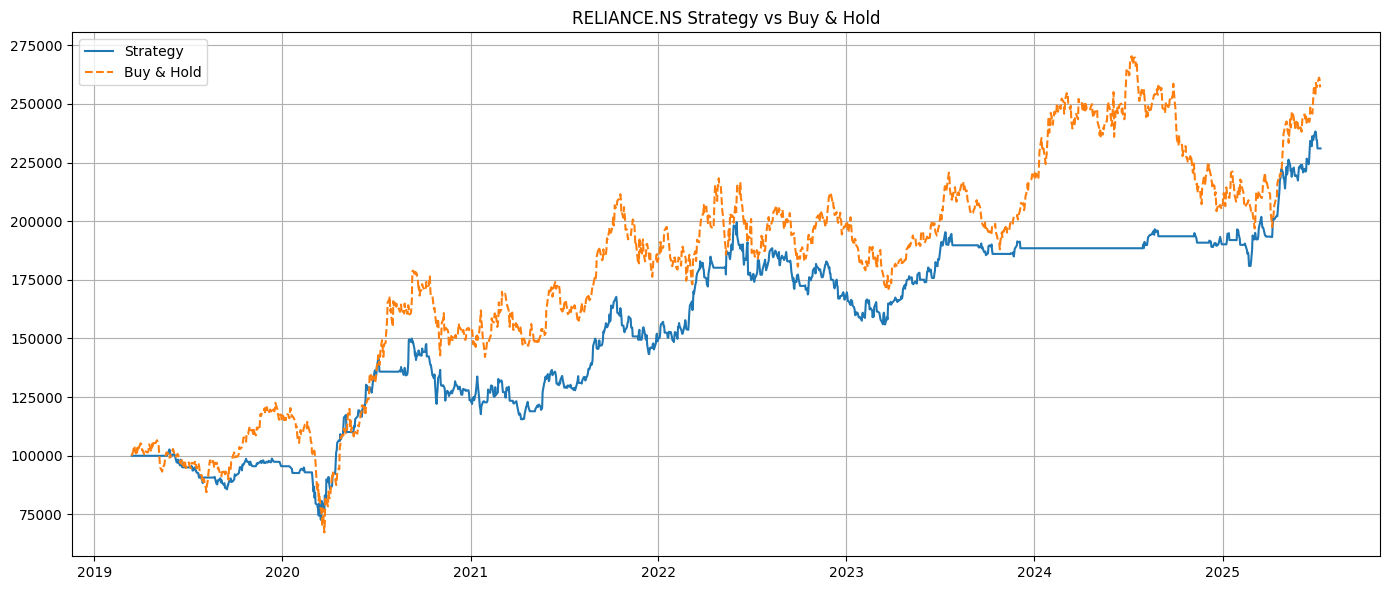


Processing INFY.NS...


/tmp/ipython-input-6-3996243062.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-6-3996243062.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-6-3996243062.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.51 | CAGR: 7.49% | MaxDD: -26.43% | Calmar: 0.28 | Trades: 314


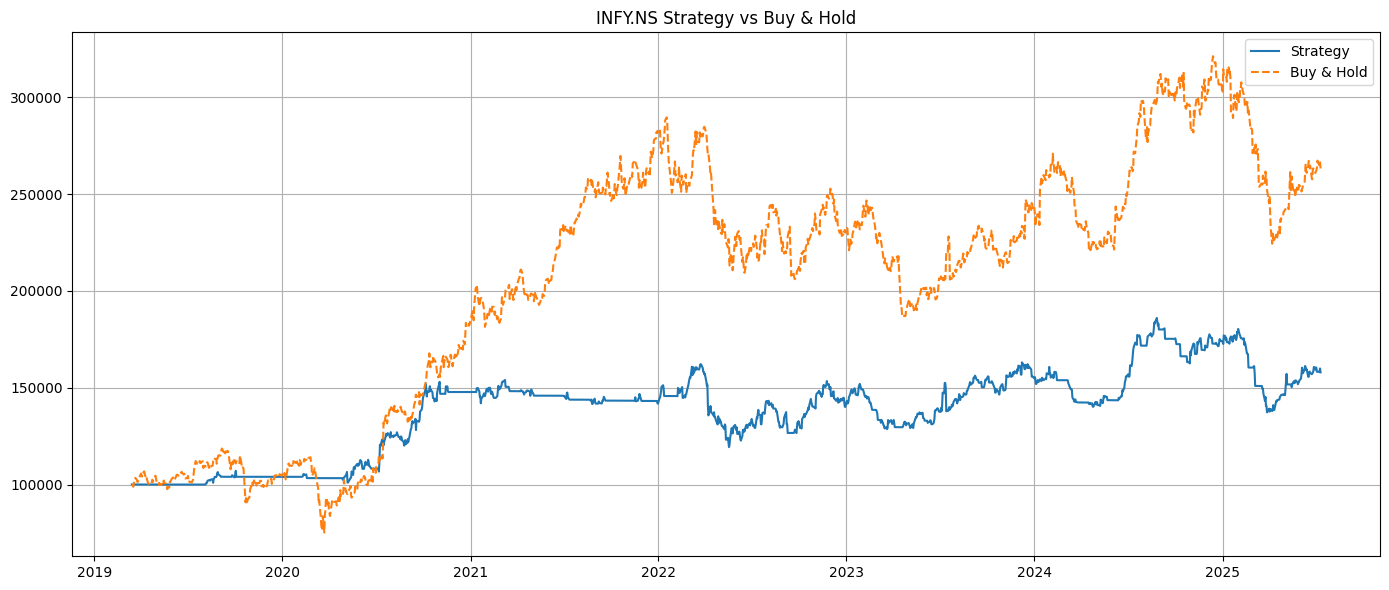


Processing TCS.NS...


/tmp/ipython-input-6-3996243062.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-6-3996243062.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-6-3996243062.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.07 | CAGR: -0.06% | MaxDD: -29.52% | Calmar: -0.00 | Trades: 265


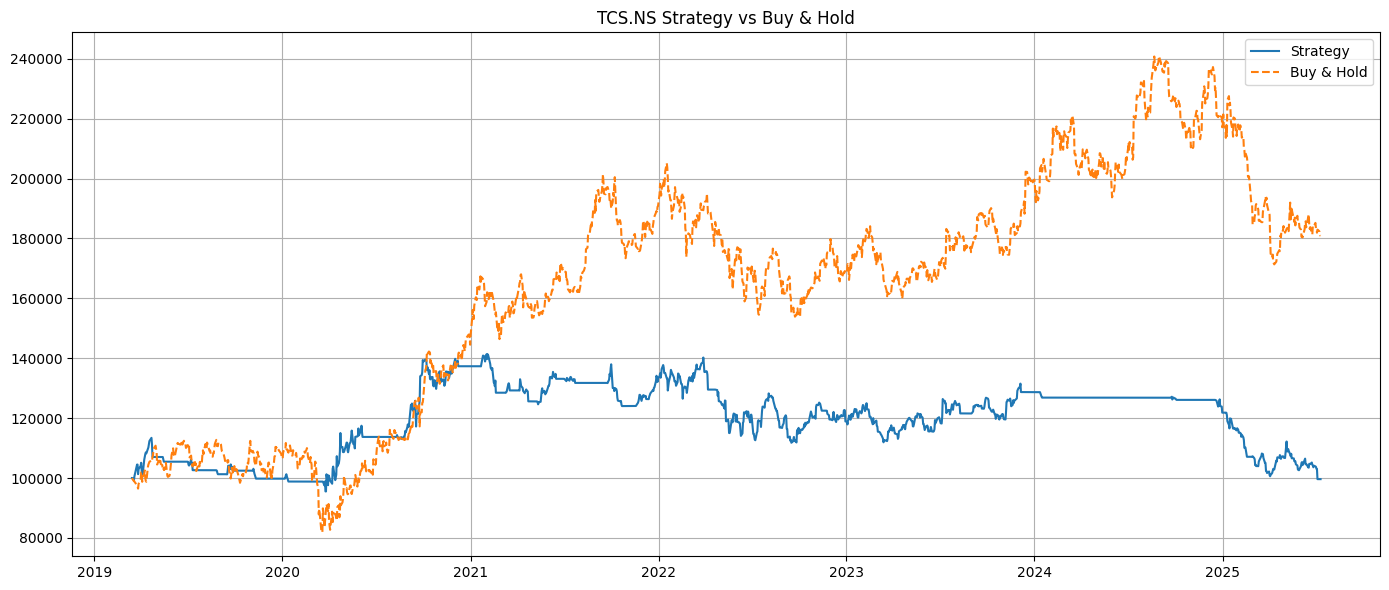


Processing ICICIBANK.NS...


/tmp/ipython-input-6-3996243062.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-6-3996243062.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-6-3996243062.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 1.19 | CAGR: 26.84% | MaxDD: -26.50% | Calmar: 1.01 | Trades: 370


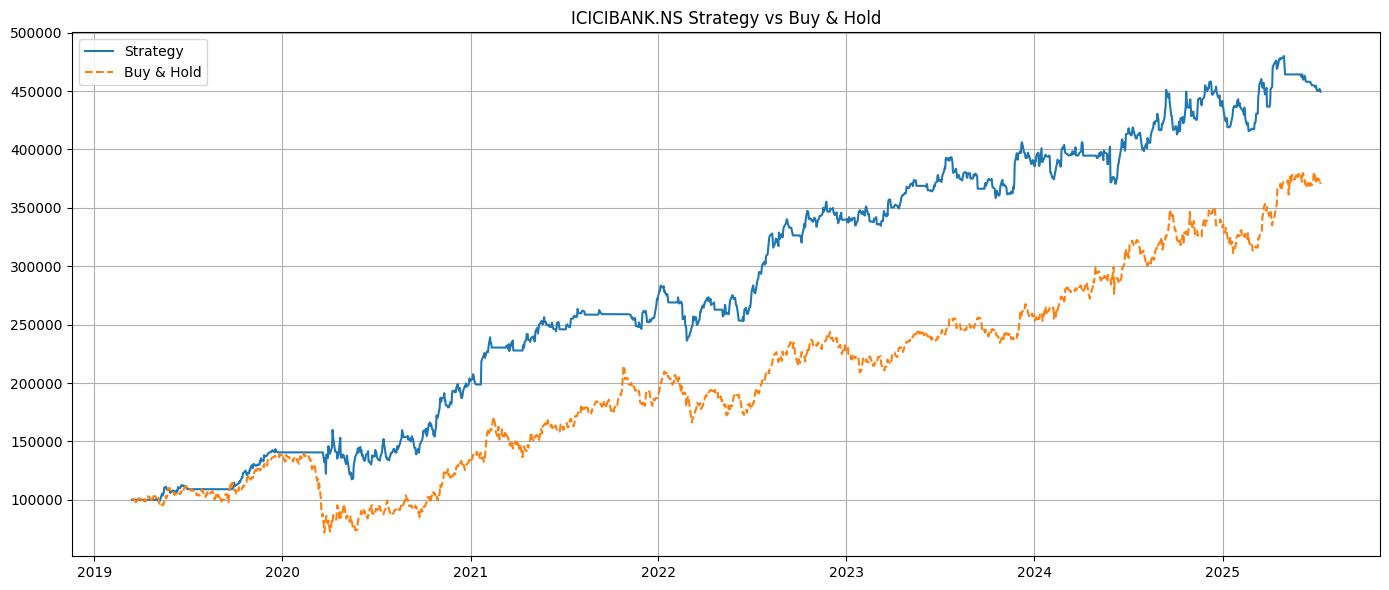


Processing NIFTYBEES.NS...


/tmp/ipython-input-6-3996243062.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-6-3996243062.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-6-3996243062.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.70 | CAGR: 6.61% | MaxDD: -21.48% | Calmar: 0.31 | Trades: 323


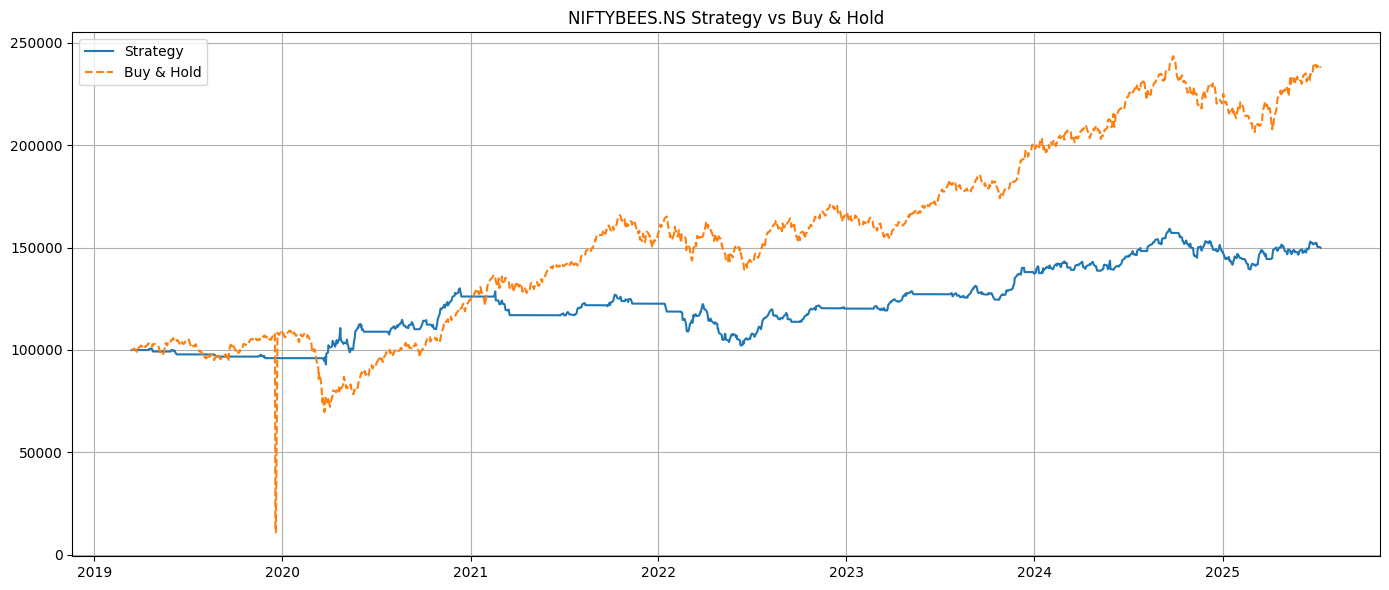


Processing BANKBEES.NS...


/tmp/ipython-input-6-3996243062.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-6-3996243062.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-6-3996243062.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Sharpe: 0.49 | CAGR: 15.07% | MaxDD: -51.37% | Calmar: 0.29 | Trades: 307


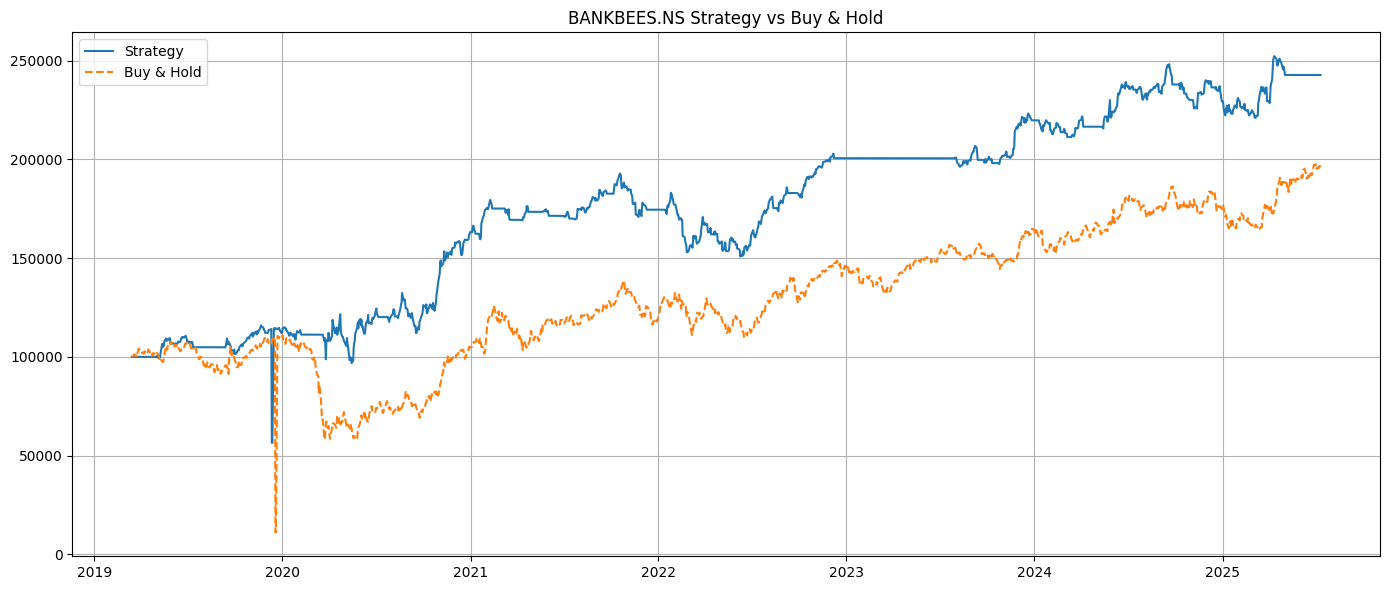

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# === Helper Indicators ===
def SMA(s, w): return s.rolling(w).mean()
def Momentum(s, p=10): return s - s.shift(p)
def ROC(s, n=10): return s.pct_change(n)
def RSI(s, p=14):
    delta = s.diff()
    gain, loss = delta.clip(lower=0), -delta.clip(upper=0)
    avg_gain = gain.rolling(p).mean()
    avg_loss = loss.rolling(p).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def MACD(s, f=12, sl=26, sig=9):
    ema1, ema2 = s.ewm(span=f, adjust=False).mean(), s.ewm(span=sl, adjust=False).mean()
    macd = ema1 - ema2
    return macd, macd.ewm(span=sig, adjust=False).mean()
def Bollinger(s, w=20, n=2):
    ma = s.rolling(w).mean()
    std = s.rolling(w).std()
    return ma + n * std, ma - n * std

# === Features ===
def compute_features(df):
    df['SMA20'] = SMA(df['Close'], 20)
    df['SMA50'] = SMA(df['Close'], 50)
    df['Momentum'] = Momentum(df['Close'], 10)
    df['RSI'] = RSI(df['Close'], 14)
    df['MACD'], df['MACD_sig'] = MACD(df['Close'])
    df['BB_up'], df['BB_low'] = Bollinger(df['Close'])
    df['Volatility'] = df['Close'].rolling(10).std()
    df['ROC'] = ROC(df['Close'], 5)
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    return df.dropna()

def rolling_train_predict(df):
    features = ['SMA20', 'SMA50', 'Momentum', 'RSI', 'MACD', 'MACD_sig', 'BB_up', 'BB_low', 'Volatility', 'ROC']
    df['Prediction'] = np.nan
    df['Prediction_Prob'] = np.nan
    retrain_period = 360

    for start in range(0, len(df) - retrain_period, retrain_period):
        train_df = df.iloc[start:start+retrain_period]
        test_df = df.iloc[start+retrain_period:start+2*retrain_period]
        if len(test_df) == 0: break
        y_train = train_df['Target']
        if y_train.nunique() < 2: continue
        X_train = train_df[features]
        X_test = test_df[features]

        model = lgb.LGBMClassifier(n_estimators=100, verbosity=-1)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:,1]
        df.loc[X_test.index, 'Prediction'] = preds
        df.loc[X_test.index, 'Prediction_Prob'] = probs

    return df.dropna()

# === Enhanced Backtest (Bull Bias Friendly) ===
def backtest(df, initial_cash=100000, transaction_cost=0.0005, base_frac=0.5):
    cash, position = initial_cash, 0
    portfolio_values, trades = [], []
    entry_price, peak_price = 0, 0
    recent_exit = False

    for i in range(5, len(df)):
        price = df['Close'].iloc[i]
        pred = df['Prediction'].iloc[i]
        prob = df['Prediction_Prob'].iloc[i]
        rsi = df['RSI'].iloc[i]
        vol = df['Volatility'].iloc[i]
        sma20 = df['SMA20'].iloc[i]
        sma50 = df['SMA50'].iloc[i]
        trend_strength = sma50 - df['SMA50'].iloc[i - 5]

        recent_avg_vol = df['Volatility'].rolling(30).mean().iloc[i]
        if vol > recent_avg_vol * 1.5:
            portfolio_values.append(cash + position * price)
            continue

        trail_stop_pct = min(0.15, 1.2 * recent_avg_vol / price)
        if position > 0:
            peak_price = max(peak_price, price)
            if price < peak_price * (1 - trail_stop_pct):
                proceeds = position * price * (1 - transaction_cost)
                cash += proceeds
                trades.append((df.index[i], 'Trailing_Stop', position, price))
                position, recent_exit = 0, True
                portfolio_values.append(cash)
                continue

        allow_rsi = 80 if trend_strength > 0 else 60
        exit_prob_thresh = 0.4 if trend_strength > 0 else 0.5
        bull_momentum = sma20 > sma50

        enter_long = (pred == 1) and (prob > 0.52) and (rsi < 75)
        exit_long = (pred == 0) and (prob < exit_prob_thresh) and (rsi > allow_rsi) and (price < sma20)

        if enter_long and cash > price:
            dynamic_frac = base_frac + (prob - 0.5) * 0.8
            if bull_momentum and prob > 0.6:
                dynamic_frac = 0.8
            shares_to_buy = int((cash * dynamic_frac) // price)
            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + transaction_cost)
                cash -= cost
                position += shares_to_buy
                entry_price, peak_price = price, price
                trades.append((df.index[i], 'Buy', shares_to_buy, price))
                recent_exit = False

        elif enter_long and recent_exit and price > entry_price * 1.02:
            dynamic_frac = base_frac + (prob - 0.5) * 0.8
            if bull_momentum and prob > 0.6:
                dynamic_frac = 0.8
            shares_to_buy = int((cash * dynamic_frac) // price)
            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + transaction_cost)
                cash -= cost
                position += shares_to_buy
                entry_price, peak_price = price, price
                trades.append((df.index[i], 'ReBuy', shares_to_buy, price))
                recent_exit = False

        elif exit_long and position > 0:
            shares_to_sell = int(position * (0.5 + (0.5 - abs(prob - 0.5)) * 0.5))
            if shares_to_sell > 0:
                proceeds = shares_to_sell * price * (1 - transaction_cost)
                cash += proceeds
                position -= shares_to_sell
                trades.append((df.index[i], 'Sell', shares_to_sell, price))
                recent_exit = True

        total_value = cash + position * price
        portfolio_values.append(total_value)

    df = df.iloc[:len(portfolio_values)].copy()
    df['Strategy'] = portfolio_values
    df['BuyHold'] = initial_cash * df['Close'] / df['Close'].iloc[0]
    df['Daily_Return'] = df['Strategy'].pct_change().fillna(0)
    return df, trades

# === Metrics ===
def compute_sharpe(df): return (df['Daily_Return'].mean() / df['Daily_Return'].std()) * np.sqrt(252)
def compute_cagr(df):
    years = (df.index[-1] - df.index[0]).days / 365.25
    return (df['Strategy'].iloc[-1] / df['Strategy'].iloc[0]) ** (1 / years) - 1
def compute_max_drawdown(df):
    peak = df['Strategy'].cummax()
    dd = (df['Strategy'] - peak) / peak
    return dd.min()
def compute_calmar(df):
    dd = abs(compute_max_drawdown(df))
    return compute_cagr(df) / dd if dd > 0 else np.nan

def plot_results(df, trades, ticker):
    plt.figure(figsize=(14,6))
    plt.plot(df.index, df['Strategy'], label='Strategy')
    plt.plot(df.index, df['BuyHold'], '--', label='Buy & Hold')
    plt.title(f'{ticker} Strategy vs Buy & Hold')
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# === Main Execution ===
tickers = ['^BSESN', 'RELIANCE.NS', 'INFY.NS', 'TCS.NS', 'ICICIBANK.NS', 'NIFTYBEES.NS', 'BANKBEES.NS']
end = datetime.today()
start = end - timedelta(days=8*365)

for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'),
                     progress=False, auto_adjust=True)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df = compute_features(df[['Close']])
    df = rolling_train_predict(df)
    df, trades = backtest(df)
    sharpe, cagr = compute_sharpe(df), compute_cagr(df)
    max_dd, calmar = compute_max_drawdown(df), compute_calmar(df)
    print(f"Sharpe: {sharpe:.2f} | CAGR: {cagr:.2%} | MaxDD: {max_dd:.2%} | Calmar: {calmar:.2f} | Trades: {len(trades)}")
    plot_results(df, trades, ticker)



Processing ^BSESN ...


/tmp/ipython-input-10-2062542510.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-10-2062542510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-10-2062542510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

Sharpe: 0.90 | CAGR: 12.47% | MaxDD: -27.89% | Calmar: 0.45 | Trades: 8


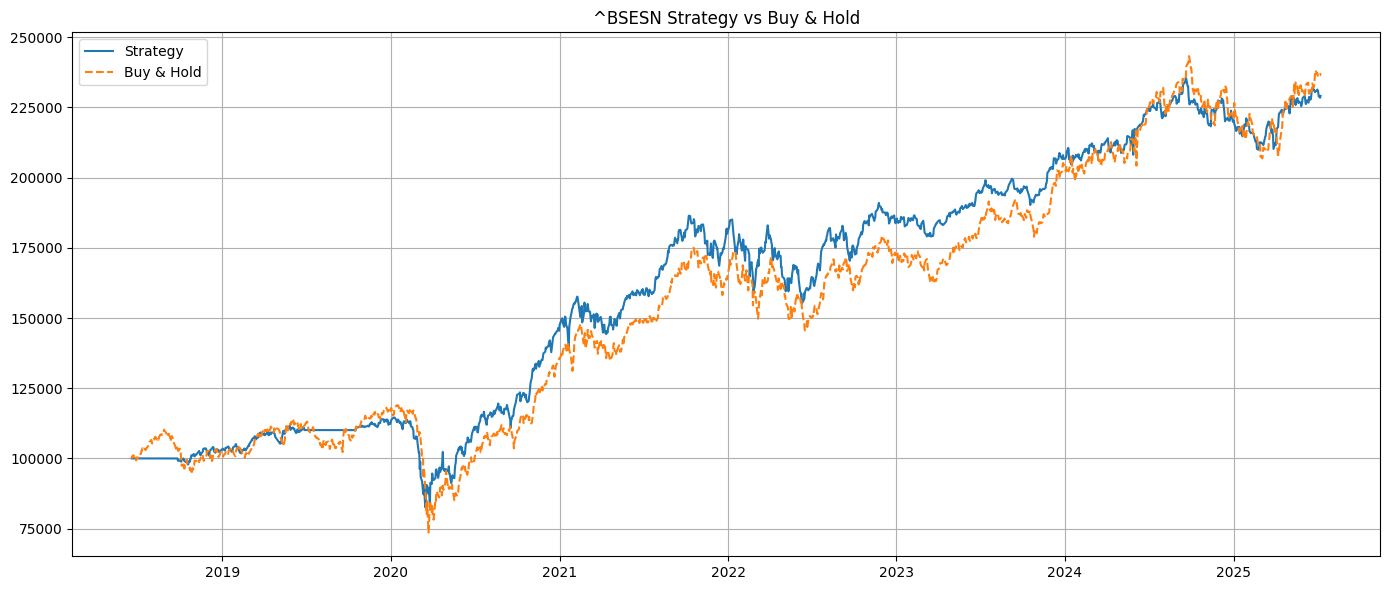


Processing ICICIBANK.NS ...


/tmp/ipython-input-10-2062542510.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-10-2062542510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-10-2062542510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

Sharpe: 0.94 | CAGR: 26.28% | MaxDD: -48.28% | Calmar: 0.54 | Trades: 8


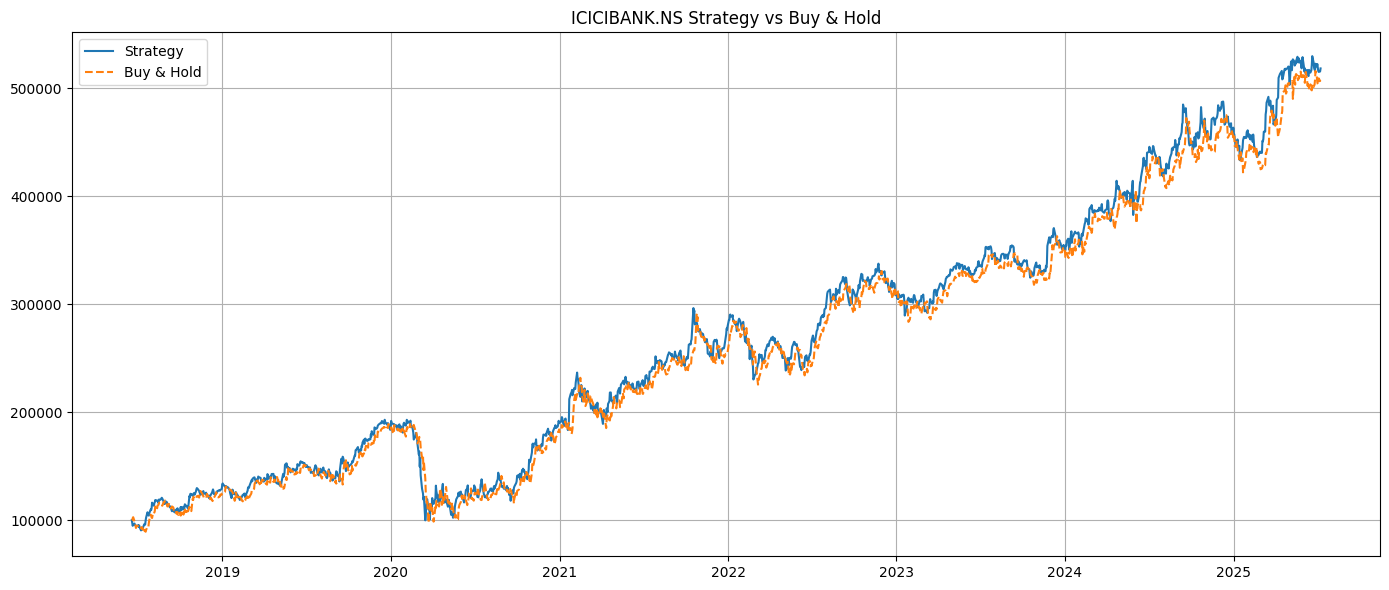


Processing INFY.NS ...


/tmp/ipython-input-10-2062542510.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-10-2062542510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-10-2062542510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

Sharpe: 0.67 | CAGR: 15.48% | MaxDD: -39.15% | Calmar: 0.40 | Trades: 21


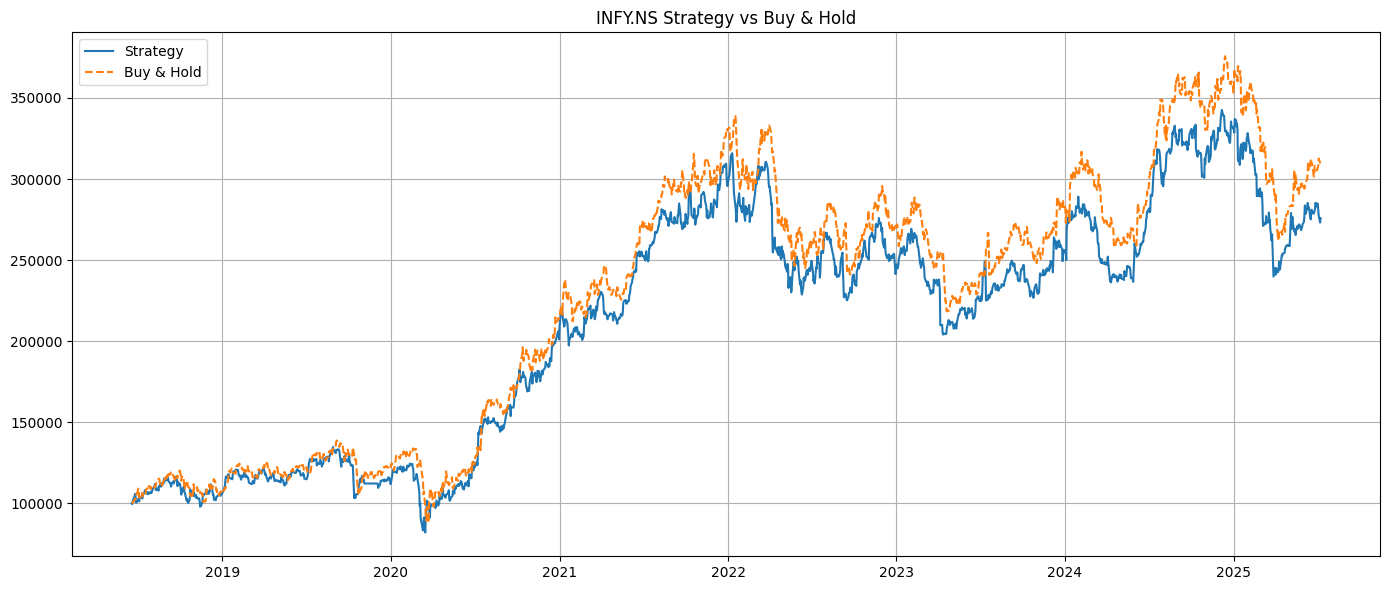


Processing HDFCBANK.NS ...


/tmp/ipython-input-10-2062542510.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-10-2062542510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-10-2062542510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

Sharpe: 0.54 | CAGR: 10.68% | MaxDD: -40.76% | Calmar: 0.26 | Trades: 10


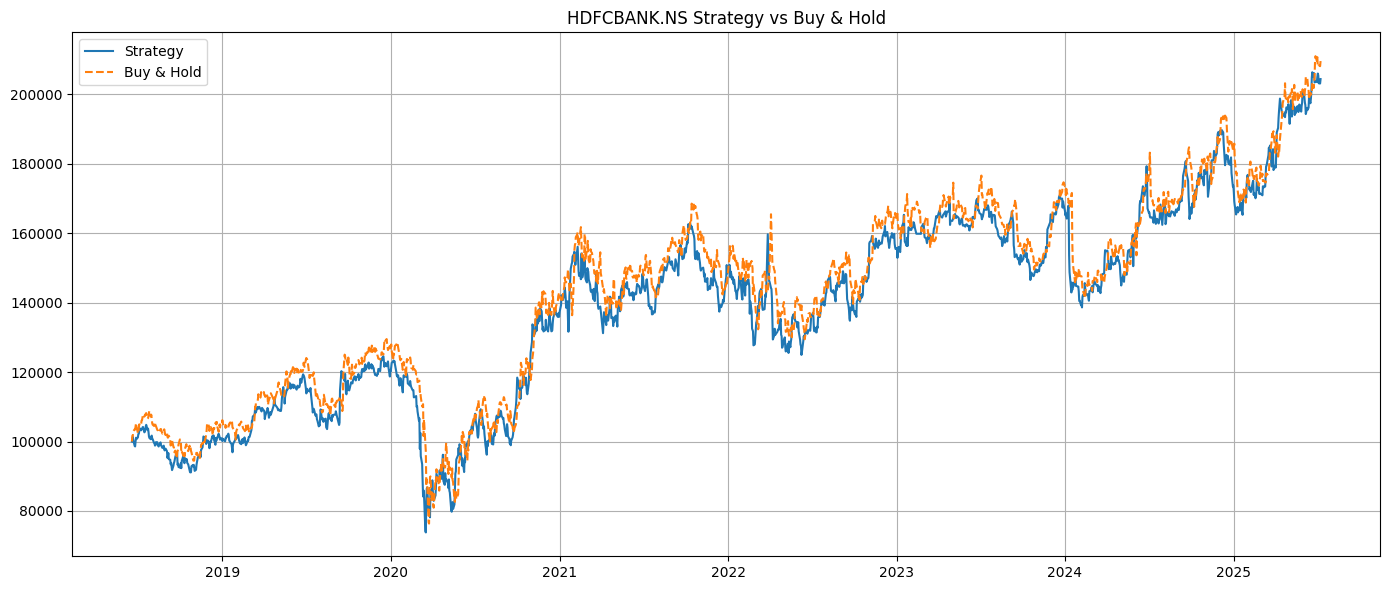


Processing RELIANCE.NS ...


/tmp/ipython-input-10-2062542510.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA20'] = SMA(df['Close'], 20)
/tmp/ipython-input-10-2062542510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA50'] = SMA(df['Close'], 50)
/tmp/ipython-input-10-2062542510.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

Sharpe: 0.78 | CAGR: 19.31% | MaxDD: -45.00% | Calmar: 0.43 | Trades: 30


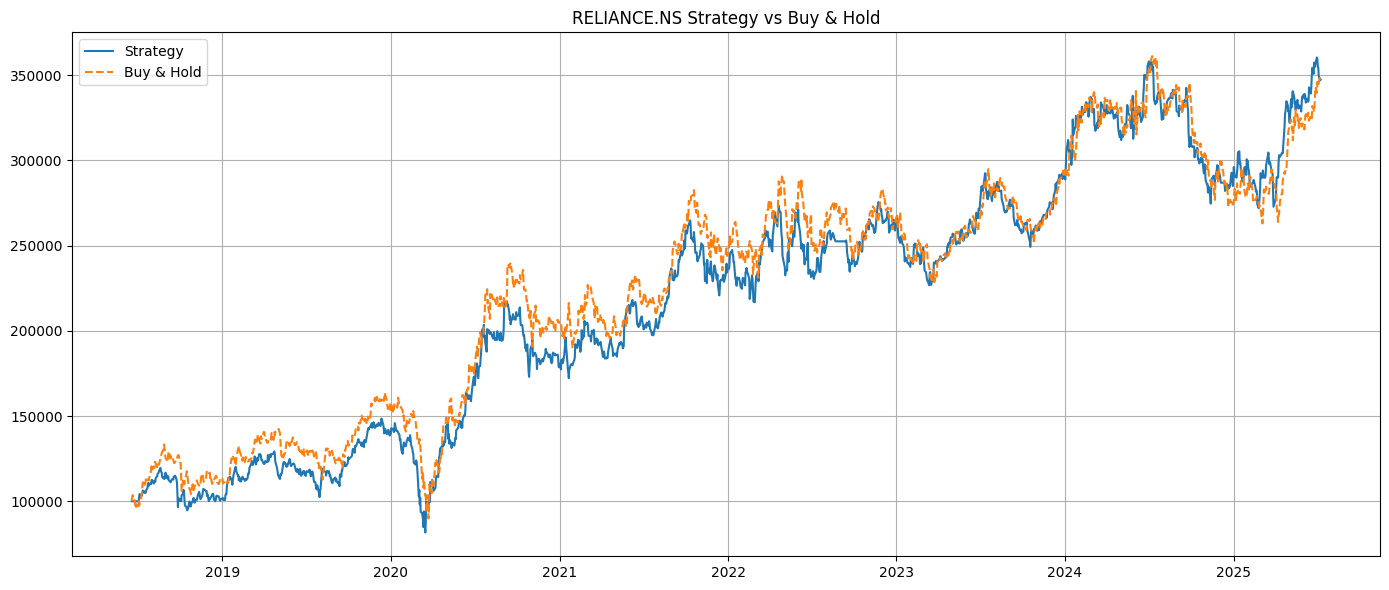

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# === Technical Indicators ===
def SMA(s, w): return s.rolling(w).mean()
def Momentum(s, p=10): return s - s.shift(p)
def ROC(s, n=10): return s.pct_change(n)
def RSI(s, p=14):
    delta = s.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(p).mean()
    avg_loss = loss.rolling(p).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def MACD(s, f=12, sl=26, sig=9):
    ema1 = s.ewm(span=f, adjust=False).mean()
    ema2 = s.ewm(span=sl, adjust=False).mean()
    macd = ema1 - ema2
    return macd, macd.ewm(span=sig, adjust=False).mean()
def Bollinger(s, w=20, n=2):
    ma = s.rolling(w).mean()
    std = s.rolling(w).std()
    return ma + n * std, ma - n * std

# === Feature Engineering ===
def compute_features(df):
    df['SMA20'] = SMA(df['Close'], 20)
    df['SMA50'] = SMA(df['Close'], 50)
    df['Momentum'] = Momentum(df['Close'], 10)
    df['RSI'] = RSI(df['Close'], 14)
    df['MACD'], df['MACD_sig'] = MACD(df['Close'])
    df['BB_up'], df['BB_low'] = Bollinger(df['Close'])
    df['Volatility'] = df['Close'].rolling(10).std()
    df['ROC'] = ROC(df['Close'], 5)
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    return df.dropna()

# === Rolling ML Training ===
def rolling_train_predict(df, retrain_period=180):
    features = ['SMA20', 'SMA50', 'Momentum', 'RSI', 'MACD', 'MACD_sig', 'BB_up', 'BB_low', 'Volatility', 'ROC']
    df['Prediction'] = np.nan
    df['Prediction_Prob'] = np.nan
    for start in range(0, len(df) - retrain_period, retrain_period):
        train = df.iloc[start:start+retrain_period]
        test = df.iloc[start+retrain_period:start+2*retrain_period]
        if len(test) == 0 or train['Target'].nunique() < 2:
            continue
        model = lgb.LGBMClassifier(n_estimators=100, verbosity=-1)
        model.fit(train[features], train['Target'])
        pred = model.predict(test[features])
        prob = model.predict_proba(test[features])[:, 1]
        df.loc[test.index, 'Prediction'] = pred
        df.loc[test.index, 'Prediction_Prob'] = prob
    return df.dropna()

# === Backtest Engine ===
def backtest(df, initial_cash=100000, transaction_cost=0.0005, base_frac=0.6, trail_stop_pct=0.08):
    cash = initial_cash
    long_position = 0
    short_position = 0
    portfolio_values = []
    trades = []
    long_entry_price = short_entry_price = 0
    peak_price = trough_price = 0

    for i in range(5, len(df)):
        price = df['Close'].iloc[i]
        pred = df['Prediction'].iloc[i]
        prob = df['Prediction_Prob'].iloc[i]
        rsi = df['RSI'].iloc[i]
        vol = df['Volatility'].iloc[i]
        sma20 = df['SMA20'].iloc[i]
        sma50 = df['SMA50'].iloc[i]
        trend_strength = sma50 - df['SMA50'].iloc[i - 5]
        bull_market = trend_strength > 0

        # === Volatility Filter ===
        recent_avg_vol = df['Volatility'].rolling(30).mean().iloc[i]
        if vol > recent_avg_vol * 1.5:
            value = cash + long_position * price - short_position * price
            portfolio_values.append(value)
            continue

        # === Long logic (always allowed if good signal) ===
        enter_long = (pred == 1) and (prob > 0.52) and (rsi < 70)
        exit_long = (pred == 0) and (prob < 0.48) and (rsi > 60) and (price < sma20)

        # === Short logic (only in downtrend) ===
        enter_short = (not bull_market) and (pred == 0) and (prob > 0.52) and (rsi > 60)
        exit_short = (pred == 1) and (prob < 0.48) and (rsi < 40) and (price > sma20)

        # === Long Entry ===
        if enter_long and cash > price:
            frac = base_frac + (prob - 0.5) * 0.8
            shares = int((cash * frac) // price)
            if shares > 0:
                cash -= shares * price * (1 + transaction_cost)
                long_position += shares
                long_entry_price = price
                peak_price = price
                trades.append((df.index[i], 'Buy', shares, price))

        # === Long Exit ===
        elif exit_long and long_position > 0:
            proceeds = long_position * price * (1 - transaction_cost)
            cash += proceeds
            trades.append((df.index[i], 'Sell', long_position, price))
            long_position = 0

        # === Short Entry ===
        if enter_short and cash > price:
            frac = base_frac + (prob - 0.5) * 0.8
            shares = int((cash * frac) // price)
            if shares > 0:
                cash += shares * price * (1 - transaction_cost)
                short_position += shares
                short_entry_price = price
                trough_price = price
                trades.append((df.index[i], 'Short_Sell', shares, price))

        # === Short Exit ===
        elif exit_short and short_position > 0:
            cost = short_position * price * (1 + transaction_cost)
            cash -= cost
            trades.append((df.index[i], 'Short_Cover', short_position, price))
            short_position = 0

        total_value = cash + long_position * price - short_position * price
        portfolio_values.append(total_value)

    df = df.iloc[:len(portfolio_values)].copy()
    df['Strategy'] = portfolio_values
    df['BuyHold'] = initial_cash * df['Close'] / df['Close'].iloc[0]
    df['Daily_Return'] = df['Strategy'].pct_change().fillna(0)

    return df, trades

# === Metrics ===
def compute_sharpe(df): return df['Daily_Return'].mean() / df['Daily_Return'].std() * np.sqrt(252)
def compute_cagr(df):
    years = (df.index[-1] - df.index[0]).days / 365.25
    return (df['Strategy'].iloc[-1] / df['Strategy'].iloc[0]) ** (1/years) - 1
def compute_max_dd(df):
    peak = df['Strategy'].cummax()
    dd = (df['Strategy'] - peak) / peak
    return dd.min()
def compute_calmar(df):
    dd = abs(compute_max_dd(df))
    return compute_cagr(df) / dd if dd else np.nan

# === Plotting ===
def plot_results(df, trades, ticker):
    plt.figure(figsize=(14,6))
    plt.plot(df.index, df['Strategy'], label='Strategy')
    plt.plot(df.index, df['BuyHold'], '--', label='Buy & Hold')
    plt.title(f'{ticker} Strategy vs Buy & Hold')
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

# === Run for Indian stocks/ETFs ===
tickers = ['^BSESN', 'ICICIBANK.NS', 'INFY.NS', 'HDFCBANK.NS', 'RELIANCE.NS']
start = datetime.today() - timedelta(days=8*365)
end = datetime.today()

for ticker in tickers:
    print(f"\nProcessing {ticker} ...")
    df = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), auto_adjust=True, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df = compute_features(df[['Close']])
    df = rolling_train_predict(df)
    df, trades = backtest(df)
    sharpe = compute_sharpe(df)
    cagr = compute_cagr(df)
    max_dd = compute_max_dd(df)
    calmar = compute_calmar(df)
    print(f"Sharpe: {sharpe:.2f} | CAGR: {cagr:.2%} | MaxDD: {max_dd:.2%} | Calmar: {calmar:.2f} | Trades: {len(trades)}")
    plot_results(df, trades, ticker)
